In [189]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
import scipy as sp
%matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.cluster import DBSCAN
import random
from kmodes.kmodes import KModes
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [150]:
# IMPORT DATA

df = pd.read_json('yelp_dataset/yelp_academic_dataset_business.json', lines=True)
print(df)


                   business_id                     name               address  \
0       6iYb2HFDywm3zjuRg0shjw      Oskar Blues Taproom          921 Pearl St   
1       tCbdrRPZA0oiIYSmHG3J0w  Flying Elephants at PDX   7000 NE Airport Way   
2       bvN78flM8NLprQ1a1y5dRg           The Reclaimory    4720 Hawthorne Ave   
3       oaepsyvc0J17qwi8cfrOWg              Great Clips    2566 Enterprise Rd   
4       PE9uqAjdw0E4-8mjGl3wVA        Crossfit Terminus   1046 Memorial Dr SE   
...                        ...                      ...                   ...   
160580  D2mHoIDXx9N8mS1pGoKV9Q       Eleven Oaks Realty                         
160581  bQX-kwVTyZgcdZGEPzce6Q             Webb's Honey    21777 State Rd 520   
160582  wvFZ06nmPmQ2-IVoPqVYLA    Painting with a Twist  2164 S Chickasaw Trl   
160583  GB75wPibj3IjNauaoCxyGA              Havana Cafe        910 NW 14th St   
160584  ngmLL5Y5OT-bYHKU0kKrYA              Zora Grille   1370 E Altamonte Dr   

                     city s

In [151]:
# CLEAN DATA

n = 10
print(df['state'].value_counts()[:n].index.tolist())


df_filtered = df[(df['state']=='MA')]
df_cluster = df_filtered.filter(items=['business_id','latitude','longitude','categories', 'review_count', 'stars'])
df_filtered = df_filtered.filter(items=['business_id','name','address','city','state','stars','review_count','is_open','attributes','categories'])

print(df_filtered)
print(df_filtered.shape[0])




['MA', 'OR', 'TX', 'FL', 'GA', 'BC', 'OH', 'CO', 'WA', 'CA']
                   business_id                                 name  \
11      hCABMnKtwo4Y9alQDxh2kw         Star Kreations Salon and Spa   
12      HPA_qyMEddpAEtFof02ixg                  Mr G's Pizza & Subs   
18      6fT0lYr_UgWSCZs_w1PBTQ                        Salter School   
26      hcRxdDg7DYryCxCoI8ySQA                    Longwood Galleria   
29      jGennaZUr2MsJyRhijNBfA                      Legal Sea Foods   
...                        ...                                  ...   
160556  87f7kR7nTz8WHnmtLM_S6w                                 O Ya   
160563  yQL8SrSETbbCI1U5esVJQw                  Ciao! Pizza & Pasta   
160568  hX-wc8LoHWSWjBwZ84ANcg          Chestnut Green Dental Group   
160569  _-nynGfhsMVVWWbAZ6YhTw                        The Jury Room   
160579  d6iEdtgLKelWKtb-2UmE2A  Master Finish Mobile Auto Detailing   

                       address     city state  stars  review_count  is_open  \
11     

## Cluster based on location

In [13]:
df_cluster

business_id   latitude  longitude  \
11      hCABMnKtwo4Y9alQDxh2kw  42.534248 -70.990948   
12      HPA_qyMEddpAEtFof02ixg  42.541155 -70.973438   
18      6fT0lYr_UgWSCZs_w1PBTQ  42.427889 -71.073475   
26      hcRxdDg7DYryCxCoI8ySQA  42.338544 -71.106842   
29      jGennaZUr2MsJyRhijNBfA  42.363442 -71.025781   
...                        ...        ...        ...   
160556  87f7kR7nTz8WHnmtLM_S6w  42.351408 -71.056867   
160563  yQL8SrSETbbCI1U5esVJQw  42.389221 -71.040882   
160568  hX-wc8LoHWSWjBwZ84ANcg  42.550054 -70.944788   
160569  _-nynGfhsMVVWWbAZ6YhTw  42.249118 -71.001071   
160579  d6iEdtgLKelWKtb-2UmE2A  42.282399 -71.225169   

                                               categories  review_count  stars  
11      Wigs, Hair Extensions, Hair Salons, Blow Dry/O...             8    4.0  
12                               Food, Pizza, Restaurants            39    4.0  
18      Specialty Schools, Massage Schools, Middle Sch...             5    2.0  
26                Restaurants, Shopping, Shopping Centers            24    2.5  
29      Sandwiches, Food, Restaurants, Breakfast & Bru...           856    3.5  
...                                                   ...           ...    ...  
160556                  Japanese, Sushi Bars, Restaurants           737    4.5  
160563                        Restaurants, Pizza, Italian           733    5.0  
160568      Health & Medical, Dentists, General Dentistry             6    3.0  
160569             Restaurants, American (New), Nightlife            30    3.0  
160579                         Automotive, Auto Detailing            11    1.0  

[36012 rows x 6 columns]

In [152]:
df_location = df_cluster.filter(items= ['latitude','longitude'])
df_location

latitude  longitude
11      42.534248 -70.990948
12      42.541155 -70.973438
18      42.427889 -71.073475
26      42.338544 -71.106842
29      42.363442 -71.025781
...           ...        ...
160556  42.351408 -71.056867
160563  42.389221 -71.040882
160568  42.550054 -70.944788
160569  42.249118 -71.001071
160579  42.282399 -71.225169

[36012 rows x 2 columns]

In [153]:
db = DBSCAN(eps=0.00001, min_samples=3, algorithm='ball_tree', metric='haversine').fit(np.radians(df_location))

In [154]:
labels = db.labels_

In [155]:
labels

array([ 0,  1,  2, ..., -1, 27, -1])

In [156]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

In [157]:
-1 in labels

True

In [158]:
df_location.iloc(0)[2]['latitude']

42.427889

In [159]:
len(colors)

2131

In [160]:
labels[1]
random.shuffle(colors)

Plotting for location clusters

/var/folders/22/yn6463hn3gl4tmn8ckzyxcb40000gn/T/ipykernel_13336/4157913855.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x,y,'ro',color=c, markeredgecolor = 'k')


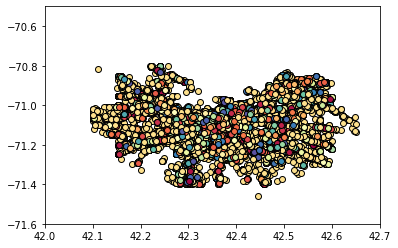

In [161]:
plt.xlim(42,42.7)
plt.ylim(-71.6,-70.5)
for i in range(0,len(labels)):
    if(labels[i] == -1):
       c = [0,0,0,1]
    c = colors[labels[i]]
    x = df_location.iloc(0)[i]['latitude']
    y = df_location.iloc(0)[i]['longitude']
    plt.plot(x,y,'ro',color=c, markeredgecolor = 'k')

Generate list of dataframe, each containing a cluster

In [162]:
cluster_list = [None] * (len(set(labels))-1)
for i in range(0,len(labels)):
    index = labels[i]
    if index != -1:
        if cluster_list[index] == None:
            cluster_list[index] = []
            cluster_list[index].append(df_cluster.iloc(0)[i])
        else:
            cluster_list[index].append(df_cluster.iloc(0)[i])

In [163]:
for i in range(0, len(cluster_list)):
    df_new = pd.DataFrame(cluster_list[i])
    cluster_list[i] = df_new

In [164]:
t = np.array(cluster_list[0]['categories']).tolist()

In [165]:
for i in range(0,len(t)):
    text = t[i]
    t[i] = [x.strip() for x in text.split(',')]


In [166]:
unique_categories = list(set(i for j in t for i in j))
df_test = pd.DataFrame(index = range(0,len(t)), columns = unique_categories)

In [167]:
for i in range(0,len(t)):
    for each in t[i]:
        df_test.loc[i,each] = each
df_test.loc[0,'Wigs']
df_test.isnull().values.any()
df_test
df_test.shape

(3, 17)

In [168]:
while(df_test.isnull().values.any()==True):
    df_test.fillna(str(random.random() * 10000),inplace=True,limit=1)

In [31]:
km = KModes(n_clusters=50, init='Huang', n_init=5, verbose=1)
clusters = km.fit_predict(df_test)

AssertionError: Cannot have more clusters (50) than data points (3).

In [32]:
l = [None] * len(set(clusters))
for i in range(0,len(clusters)):
    index = clusters[i]
    if index != -1:
        if l[index] == None:
            l[index] = []
            l[index].append(cluster_list[0].iloc(0)[i])
        else:
            l[index].append(cluster_list[0].iloc(0)[i])


NameError: name 'clusters' is not defined

## Clustering for each location cluster

The result is expected to be a list, with each element as a list of clusters. 

In [169]:
res = []
for i in range(0,len(cluster_list)):
    print("%d run:" %(i))
    t = np.array(cluster_list[i]['categories']).tolist()
    for j in range(0,len(t)):
        text = t[j]
        if(text == None):
            text = 'None'
        t[j] = [x.strip() for x in text.split(',')]
    unique_categories = list(set(k for j in t for k in j))
    df_test = pd.DataFrame(index = range(0,len(t)), columns = unique_categories)
    for j in range(0,len(t)):
        for each in t[j]:
            df_test.loc[j,each] = 1/len(t[j])
        df_test.fillna(0,inplace=True)
    km = KMeans(n_clusters=int(min(df_test.shape[0]/4+1,50)),verbose=1).fit(df_test)
    clusters = km.labels_
    l = [None] * len(set(clusters))
    for j in range(0,len(clusters)):
        index = clusters[j]
        if index != -1:
            if l[index] == None:
                l[index] = []
                l[index].append(cluster_list[i].iloc(0)[j])
            else:
                l[index].append(cluster_list[i].iloc(0)[j])
    res.append(l)

0 run:
Initialization complete
Iteration 0, inertia 0.7619047619047619.
Iteration 1, inertia 0.4126984126984126.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9523809523809523.
Iteration 1, inertia 0.4126984126984127.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7619047619047619.
Iteration 1, inertia 0.4126984126984126.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9523809523809523.
Iteration 1, inertia 0.4126984126984126.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7619047619047619.
Iteration 1, inertia 0.4126984126984127.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7619047619047619.
Iteration 1, inertia 0.4126984126984126.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7619047619047619.
Iteration 1, ine

Initialization complete
Iteration 0, inertia 8.594393939393939
Iteration 1, inertia 5.510834046244761
Iteration 2, inertia 5.383449361815433
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 8.504278499278499
Iteration 1, inertia 5.303907765740041
Iteration 2, inertia 5.212107337547813
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 8.46352813852814
Iteration 1, inertia 5.567040798432167
Iteration 2, inertia 5.489680128238163
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 8.859978354978356
Iteration 1, inertia 5.543413064889255
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 9.033603896103896
Iteration 1, inertia 5.706654968047825
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.612727272727273
Iteration 1, inertia 5.513110810485811
Iteration 2, inertia 5.403218964016584
Con

Iteration 1, inertia 1.4350925925925926
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.625
Iteration 1, inertia 1.5078125000000002
Iteration 2, inertia 1.4755555555555557
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 2.701666666666667
Iteration 1, inertia 1.4716358024691358
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4972222222222227
Iteration 1, inertia 1.5852777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6805555555555554
Iteration 1, inertia 1.4270833333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3888888888888893
Iteration 1, inertia 1.5216666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.388888888888889
Iteration 1, inertia 1.5077777777777777
Converged at iteration 1: strict co

Iteration 18, inertia 455.7612164700554
Iteration 19, inertia 455.7573532934906
Iteration 20, inertia 455.7542769842198
Iteration 21, inertia 455.7533952480172
Iteration 22, inertia 455.75023574875087
Iteration 23, inertia 455.7479300658912
Iteration 24, inertia 455.74502149966224
Iteration 25, inertia 455.7387756338122
Iteration 26, inertia 455.7353162032908
Converged at iteration 26: strict convergence.
Initialization complete
Iteration 0, inertia 685.7148621111231
Iteration 1, inertia 491.24676916234955
Iteration 2, inertia 476.8718332006519
Iteration 3, inertia 471.41697350792526
Iteration 4, inertia 467.867127211626
Iteration 5, inertia 465.46934287855953
Iteration 6, inertia 463.4392755214824
Iteration 7, inertia 462.08666270788945
Iteration 8, inertia 461.88619355935896
Iteration 9, inertia 461.8726808721432
Iteration 10, inertia 461.8662010549813
Iteration 11, inertia 461.8614718323347
Iteration 12, inertia 461.85663264549464
Iteration 13, inertia 461.8486143376489
Iteration 14

Initialization complete
Iteration 0, inertia 40.245132222275075
Iteration 1, inertia 29.12699016854165
Iteration 2, inertia 28.593980993921058
Iteration 3, inertia 28.25345858013938
Iteration 4, inertia 28.21122432274515
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 40.05907676979105
Iteration 1, inertia 28.4990057636185
Iteration 2, inertia 28.118847173739066
Iteration 3, inertia 27.831188401468605
Iteration 4, inertia 27.746518807997795
Iteration 5, inertia 27.700475042095213
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 40.89856063248919
Iteration 1, inertia 29.02928850733274
Iteration 2, inertia 28.319339814222804
Iteration 3, inertia 27.978620074503873
Iteration 4, inertia 27.841150157553592
Iteration 5, inertia 27.81365827602732
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 40.48039075342647
Iteration 1, inertia 28.772387399560245
Iteration 2, ine

22 run:
Initialization complete
Iteration 0, inertia 20.205781026733412
Iteration 1, inertia 13.290158192625064
Iteration 2, inertia 13.157580320151133
Iteration 3, inertia 13.097593129322954
Iteration 4, inertia 13.073536780815973
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 19.32707428374095
Iteration 1, inertia 12.907067249768941
Iteration 2, inertia 12.828933080007742
Iteration 3, inertia 12.786884287742932
Iteration 4, inertia 12.745421476517045
Iteration 5, inertia 12.731490291849907
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 18.592170052170054
Iteration 1, inertia 12.81163694927616
Iteration 2, inertia 12.518422209481798
Iteration 3, inertia 12.492519291412213
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 18.86938873976753
Iteration 1, inertia 12.664302014178254
Iteration 2, inertia 12.586745383525848
Converged at iteration 2: strict converge

Initialization complete
Iteration 0, inertia 21.34657240246526
Iteration 1, inertia 14.706412179510249
Iteration 2, inertia 14.628762548185696
Iteration 3, inertia 14.607197838096647
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 21.381890516890522
Iteration 1, inertia 14.479880585909484
Iteration 2, inertia 14.259842783491095
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 21.54755886970173
Iteration 1, inertia 14.8978962711621
Iteration 2, inertia 14.386449809060156
Iteration 3, inertia 14.3588201615404
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 21.42251002965289
Iteration 1, inertia 14.310324965086297
Iteration 2, inertia 14.216025993517066
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 20.95435999185999
Iteration 1, inertia 14.15991141655208
Iteration 2, inertia 14.100144036316632
Iteration 3, inertia 14.0

Initialization complete
Iteration 0, inertia 11.42522126022126
Iteration 1, inertia 7.517538595993954
Iteration 2, inertia 7.397809450060344
Iteration 3, inertia 7.322725188800868
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 11.710541927208592
Iteration 1, inertia 7.789631505362802
Iteration 2, inertia 7.634016952761745
Iteration 3, inertia 7.583336950857785
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 12.08968253968254
Iteration 1, inertia 7.5384797154407694
Iteration 2, inertia 7.407548248656526
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 12.152728818800249
Iteration 1, inertia 7.993551042205464
Iteration 2, inertia 7.928195380142659
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 11.728146544813212
Iteration 1, inertia 8.126682024169067
Iteration 2, inertia 8.104729883830792
Converged at iteration 2: str

Initialization complete
Iteration 0, inertia 27.971425102675106
Iteration 1, inertia 19.25087413409604
Iteration 2, inertia 18.48272709895381
Iteration 3, inertia 18.17535799395107
Iteration 4, inertia 18.161710811297546
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 27.37543611030624
Iteration 1, inertia 18.613553269077343
Iteration 2, inertia 18.110118587853606
Iteration 3, inertia 17.964342112662514
Iteration 4, inertia 17.908302971779705
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 28.652240979919554
Iteration 1, inertia 19.2586460336865
Iteration 2, inertia 18.44890973988664
Iteration 3, inertia 18.21782226455325
Iteration 4, inertia 18.19828451641953
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 27.56684742506171
Iteration 1, inertia 18.463185860702318
Iteration 2, inertia 18.083485119715377
Iteration 3, inertia 17.986784927885463
Iteration 4, ine

Initialization complete
Iteration 0, inertia 2.743333333333334
Iteration 1, inertia 1.9681851851851855
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7322222222222226
Iteration 1, inertia 1.940851851851852
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.612222222222223
Iteration 1, inertia 1.9385090702947847
Iteration 2, inertia 1.840601851851852
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 2.543333333333334
Iteration 1, inertia 1.7661851851851855
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.532222222222223
Iteration 1, inertia 1.6748518518518516
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.732222222222223
Iteration 1, inertia 1.9488518518518516
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3455555555555554
Ite

Initialization complete
Iteration 0, inertia 16.001392496392498
Iteration 1, inertia 10.362287542014828
Iteration 2, inertia 10.225269226112763
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 15.443186513662702
Iteration 1, inertia 10.814357009096076
Iteration 2, inertia 10.66369639157139
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 15.97128793604984
Iteration 1, inertia 10.410944289820204
Iteration 2, inertia 10.297337404611508
Iteration 3, inertia 10.088700680038386
Iteration 4, inertia 10.053923303328064
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 16.03296971987448
Iteration 1, inertia 10.05921304926154
Iteration 2, inertia 9.9669345977242
Iteration 3, inertia 9.792049290333418
Iteration 4, inertia 9.699790390835096
Iteration 5, inertia 9.636776769967247
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 15.87

Initialization complete
Iteration 0, inertia 2.5292517006802724
Iteration 1, inertia 1.7777210884353742
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9374149659863944
Iteration 1, inertia 1.7089002267573696
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8809523809523814
Iteration 1, inertia 1.8500566893424037
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9904761904761905
Iteration 1, inertia 1.8940476190476192
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.927210884353742
Iteration 1, inertia 1.771598639455782
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8238095238095244
Iteration 1, inertia 1.763043863378685
Iteration 2, inertia 1.6728377065111761
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 2.6244897959183677

64 run:
Initialization complete
Iteration 0, inertia 9.350211825211826
Iteration 1, inertia 6.2587266005887034
Iteration 2, inertia 6.073823499252071
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 9.164317164317163
Iteration 1, inertia 6.202678424073609
Iteration 2, inertia 6.0451509599912265
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 9.315245865245867
Iteration 1, inertia 6.177598825697866
Iteration 2, inertia 6.1366668505656605
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 9.66705747955748
Iteration 1, inertia 6.4438016330773245
Iteration 2, inertia 6.367259270092232
Iteration 3, inertia 6.331641512881593
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 9.367414067414067
Iteration 1, inertia 6.1243405002184765
Iteration 2, inertia 6.060523218302522
Converged at iteration 2: strict convergence.
Initialization

Iteration 1, inertia 0.5333333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9
Iteration 1, inertia 0.5333333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9916666666666667
Iteration 1, inertia 0.5645833333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1916666666666667
Iteration 1, inertia 0.5645833333333333
Converged at iteration 1: strict convergence.
70 run:
Initialization complete
Iteration 0, inertia 5.6068376068376065
Iteration 1, inertia 4.133736942070275
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.173687423687424
Iteration 1, inertia 3.662706213539547
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.720309320309321
Iteration 1, inertia 3.7834695088861756
Converged at iteration 1: strict convergence.
Initialization complete
I

Initialization complete
Iteration 0, inertia 4.907596371882086
Iteration 1, inertia 2.995124041680164
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.558390022675738
Iteration 1, inertia 2.868693310657597
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.2480158730158735
Iteration 1, inertia 2.8444444444444446
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.955215419501133
Iteration 1, inertia 2.8871482353625204
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.762896825396825
Iteration 1, inertia 2.816765873015873
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.214285714285714
Iteration 1, inertia 2.8304535934744264
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.691326530612245
Iteration 1, inertia 2.8308266014739223
Itera

Initialization complete
Iteration 0, inertia 10.885569985569987
Iteration 1, inertia 6.668007604797571
Iteration 2, inertia 6.632252802752802
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 9.85424482924483
Iteration 1, inertia 6.664829850009589
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 10.299639249639252
Iteration 1, inertia 6.958601830474053
Iteration 2, inertia 6.937411866682701
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 9.136375661375661
Iteration 1, inertia 6.458338211885044
Iteration 2, inertia 6.406180264180264
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 9.572214205547539
Iteration 1, inertia 6.658218796851838
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 10.179906204906205
Iteration 1, inertia 6.345334601854209
Converged at iteration 1: strict conver

Iteration 0, inertia 1.0.
Iteration 1, inertia 0.4375000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8125.
Iteration 1, inertia 0.4375000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8125.
Iteration 1, inertia 0.4375000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.4375000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8125.
Iteration 1, inertia 0.4375000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8125.
Iteration 1, inertia 0.4375000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8125.
Iteration 1, inertia 0.4375000000000001.
Converged at iteration 1: strict convergence.
91 run:
Initialization complete
Iteration 0, inert

96 run:
Initialization complete
Iteration 0, inertia 16.399063907473
Iteration 1, inertia 10.79643312423909
Iteration 2, inertia 10.783047959756294
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 16.28452380952381
Iteration 1, inertia 10.768383904415254
Iteration 2, inertia 10.749856315421791
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 15.841903012812104
Iteration 1, inertia 10.630449062336611
Iteration 2, inertia 10.381059028016251
Iteration 3, inertia 10.34359817389868
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 15.894664902998237
Iteration 1, inertia 10.284389797695875
Iteration 2, inertia 10.213973188231524
Iteration 3, inertia 10.173795858242288
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 17.251196342938766
Iteration 1, inertia 11.216296234774031
Iteration 2, inertia 11.086860011045195
Iteration 3, i

Initialization complete
Iteration 0, inertia 17.111587301587303
Iteration 1, inertia 11.25717149776799
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 16.131349206349206
Iteration 1, inertia 10.84419618490671
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 17.795026455026456
Iteration 1, inertia 11.318368768371545
Iteration 2, inertia 11.127474159108088
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 17.726547619047622
Iteration 1, inertia 11.071758928571427
Iteration 2, inertia 10.958807429453262
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 16.46388888888889
Iteration 1, inertia 11.172779933372524
Iteration 2, inertia 11.035619929453262
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 17.804603174603177
Iteration 1, inertia 10.920728275834144
Iteration 2, inertia 10.82777

Initialization complete
Iteration 0, inertia 2.8000000000000003
Iteration 1, inertia 1.4566666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.22
Iteration 1, inertia 1.334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.02
Iteration 1, inertia 1.334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2200000000000006
Iteration 1, inertia 1.334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2200000000000006
Iteration 1, inertia 1.334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.466666666666667
Iteration 1, inertia 1.4566666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3866666666666667
Iteration 1, inertia 1.4977777777777779
Converged at iteration 1: strict convergence.
Initialization complete
Iterati

Initialization complete
Iteration 0, inertia 9.268888888888888
Iteration 1, inertia 5.498324074074075
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 9.406388888888888
Iteration 1, inertia 6.009619047619048
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 9.458333333333334
Iteration 1, inertia 5.991322916666666
Iteration 2, inertia 5.854089002267573
Iteration 3, inertia 5.747810185185185
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 9.291666666666668
Iteration 1, inertia 6.1163240740740745
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 9.543055555555556
Iteration 1, inertia 6.3255439814814824
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 9.294166666666666
Iteration 1, inertia 5.770314525462963
Iteration 2, inertia 5.721007936507936
Converged at iteration 2: strict conver

118 run:
Initialization complete
Iteration 0, inertia 2.6479166666666663
Iteration 1, inertia 1.6816840277777776
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2645833333333334
Iteration 1, inertia 1.4785590277777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6479166666666667
Iteration 1, inertia 1.5504960317460317
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9222222222222225
Iteration 1, inertia 1.6816840277777776
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8916666666666666
Iteration 1, inertia 1.609375
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3895833333333334
Iteration 1, inertia 1.6660590277777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.0416666666666665
Iteration 1, inertia 1.75833333333333

Initialization complete
Iteration 0, inertia 19.274813361241932
Iteration 1, inertia 13.199341335875623
Iteration 2, inertia 12.91462029752664
Iteration 3, inertia 12.672083388876292
Iteration 4, inertia 12.570924781211064
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 19.514272632129778
Iteration 1, inertia 12.497056319705834
Iteration 2, inertia 12.344298703772147
Converged at iteration 2: strict convergence.
124 run:
Initialization complete
Iteration 0, inertia 4.399773242630386
Iteration 1, inertia 2.769510410224696
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.405555555555556
Iteration 1, inertia 2.589618055555556
Iteration 2, inertia 2.534963466868229
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 4.038888888888889
Iteration 1, inertia 2.843246409674981
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.24

Iteration 0, inertia 0.0.
Converged at iteration 0: center shift 0.0 within tolerance 0.0.
132 run:
Initialization complete
Iteration 0, inertia 4.933333333333334
Iteration 1, inertia 2.8232142857142857
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.652380952380954
Iteration 1, inertia 2.6465608465608463
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.5357142857142865
Iteration 1, inertia 2.6845238095238093
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.50952380952381
Iteration 1, inertia 3.1056277056277057
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.464285714285715
Iteration 1, inertia 2.8290816326530615
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.426190476190477
Iteration 1, inertia 2.584722222222222
Converged at iteration 1: strict convergence.
Initial

Iteration 0, inertia 3.3000000000000003
Iteration 1, inertia 2.0785714285714283
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.4250000000000003
Iteration 1, inertia 2.036904761904762
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5583333333333336
Iteration 1, inertia 2.1904761904761902
Converged at iteration 1: strict convergence.
139 run:
Initialization complete
Iteration 0, inertia 6.847619047619048
Iteration 1, inertia 4.414719623960695
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.7846230158730165
Iteration 1, inertia 4.789479166666666
Iteration 2, inertia 4.681752645502645
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 6.685416666666667
Iteration 1, inertia 4.660960648148149
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.687619047619048
Iteration 1, inerti

Initialization complete
Iteration 0, inertia 11.129067546210404
Iteration 1, inertia 7.197139634368058
Iteration 2, inertia 7.112491875959138
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 11.1872397443826
Iteration 1, inertia 7.515909907603937
Iteration 2, inertia 7.351270133305848
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 11.202535559678417
Iteration 1, inertia 7.7648133596873095
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 10.75472582972583
Iteration 1, inertia 6.904949778420066
Iteration 2, inertia 6.769789596374064
Iteration 3, inertia 6.701291973614643
Iteration 4, inertia 6.6619788397963005
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11.23805143269429
Iteration 1, inertia 7.267093647254402
Iteration 2, inertia 7.191429244256626
Converged at iteration 2: strict convergence.
Initialization complete

Iteration 0, inertia 0.7954545454545454.
Iteration 1, inertia 0.5151515151515151.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.5151515151515151.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0454545454545454.
Iteration 1, inertia 0.5151515151515151.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7954545454545454.
Iteration 1, inertia 0.5151515151515151.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.5151515151515151.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7954545454545454.
Iteration 1, inertia 0.5151515151515151.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0454545454545454.
Iteration 1, inertia 0.5151515151515151.
Converged at iteration 1: strict c

Iteration 0, inertia 1.9733333333333338
Iteration 1, inertia 0.9644444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7333333333333336
Iteration 1, inertia 0.9644444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7533333333333334
Iteration 1, inertia 1.1544444444444446
Converged at iteration 1: strict convergence.
160 run:
Initialization complete
Iteration 0, inertia 0.6700000000000002.
Iteration 1, inertia 0.3400000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6700000000000002.
Iteration 1, inertia 0.3400000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7000000000000002.
Iteration 1, inertia 0.3400000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7000000000000002.
Iteration 1, inertia 0.3400000000000001.
Con

Initialization complete
Iteration 0, inertia 0.8571428571428571
Iteration 1, inertia 0.45793650793650786
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0095238095238095
Iteration 1, inertia 0.4579365079365079
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0095238095238095
Iteration 1, inertia 0.45793650793650786
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8809523809523808
Iteration 1, inertia 0.45793650793650786
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.857142857142857
Iteration 1, inertia 0.45793650793650786
Converged at iteration 1: strict convergence.
166 run:
Initialization complete
Iteration 0, inertia 4.771608946608947
Iteration 1, inertia 2.74829588401017
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.060497835497836
Iteration 1, inertia 2.69484

Initialization complete
Iteration 0, inertia 16.472469521219523
Iteration 1, inertia 10.748117245129244
Iteration 2, inertia 10.58021904131289
Iteration 3, inertia 10.559068204906499
Iteration 4, inertia 10.53417725840444
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 16.943533133533133
Iteration 1, inertia 11.40708289792198
Iteration 2, inertia 11.008859229592595
Iteration 3, inertia 10.86184348027583
Iteration 4, inertia 10.846503113288826
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 16.867967541717544
Iteration 1, inertia 10.758794421541417
Iteration 2, inertia 10.503649697231044
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 16.98693389282675
Iteration 1, inertia 11.194705825758145
Iteration 2, inertia 10.801319681295894
Iteration 3, inertia 10.773284190078275
Iteration 4, inertia 10.732748944113892
Iteration 5, inertia 10.700876290772719
Iteration 6

Initialization complete
Iteration 0, inertia 16.050157351066442
Iteration 1, inertia 10.424679274769227
Iteration 2, inertia 9.957029482212112
Iteration 3, inertia 9.917906331383064
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 15.144179339179338
Iteration 1, inertia 10.377379793652116
Iteration 2, inertia 10.291301501544176
Iteration 3, inertia 10.198369402778745
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 15.101776102685193
Iteration 1, inertia 10.099600461835744
Iteration 2, inertia 9.90804841807114
Iteration 3, inertia 9.893379284481204
Iteration 4, inertia 9.883282067032138
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 15.095043390952483
Iteration 1, inertia 9.814607840495377
Iteration 2, inertia 9.73781414425999
Iteration 3, inertia 9.666404267429701
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 16.41

Initialization complete
Iteration 0, inertia 17.414945744290982
Iteration 1, inertia 10.929320925863989
Iteration 2, inertia 10.753675042660163
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 16.588103483817772
Iteration 1, inertia 10.866599363819603
Iteration 2, inertia 10.724578616363964
Iteration 3, inertia 10.601852762937385
Iteration 4, inertia 10.575740983323234
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 16.741542207792207
Iteration 1, inertia 11.116186274274437
Iteration 2, inertia 11.030944805058466
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 16.17790764790765
Iteration 1, inertia 11.032363377499305
Iteration 2, inertia 10.845763744916177
Iteration 3, inertia 10.817547963931645
Iteration 4, inertia 10.745788176329842
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 17.091572356215213
Iteration 1, iner

Initialization complete
Iteration 0, inertia 5.637835775335775
Iteration 1, inertia 3.991491147741148
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.836355311355311
Iteration 1, inertia 3.7233551704705548
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.722557997557997
Iteration 1, inertia 3.2380850630850624
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.825335775335776
Iteration 1, inertia 3.8424710705960705
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.415613553113552
Iteration 1, inertia 3.739588348159778
Iteration 2, inertia 3.6819377915531764
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 6.142002442002442
Iteration 1, inertia 3.859484959484959
Iteration 2, inertia 3.730697080697081
Converged at iteration 2: strict convergence.
Initialization complete
Iterat

Initialization complete
Iteration 0, inertia 2.4785714285714286
Iteration 1, inertia 1.6654998110355252
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8616402116402115
Iteration 1, inertia 1.4511558327034517
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1119047619047624
Iteration 1, inertia 1.3604072184429326
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1119047619047624
Iteration 1, inertia 1.3604072184429326
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4552154195011333
Iteration 1, inertia 1.2570641219450742
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.18968253968254
Iteration 1, inertia 1.2570641219450742
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.223015873015873
Iteration 1, inertia 1.4333238851095993

Iteration 1, inertia 0.471938775510204
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0714285714285714
Iteration 1, inertia 0.471938775510204
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7448979591836735
Iteration 1, inertia 0.471938775510204
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7448979591836735
Iteration 1, inertia 0.471938775510204
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8877551020408163
Iteration 1, inertia 0.471938775510204
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8877551020408164
Iteration 1, inertia 0.471938775510204
Converged at iteration 1: strict convergence.
202 run:
Initialization complete
Iteration 0, inertia 0.4166666666666667
Iteration 1, inertia 0.25
Converged at iteration 1: strict convergence.
Initialization complete
I

Initialization complete
Iteration 0, inertia 2.1626984126984126
Iteration 1, inertia 1.3857473544973544
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4801587301587302
Iteration 1, inertia 1.5679327286470142
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.751984126984127
Iteration 1, inertia 1.5096560846560847
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.246031746031746
Iteration 1, inertia 1.4900793650793647
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1626984126984126
Iteration 1, inertia 1.3857473544973544
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7182539682539684
Iteration 1, inertia 1.3857473544973544
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3710317460317456
Iteration 1, inertia 1.385747354497354

Initialization complete
Iteration 0, inertia 7.430844155844156
Iteration 1, inertia 4.974485930735931
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.8404040404040405
Iteration 1, inertia 5.157135115417274
Iteration 2, inertia 5.128701480592236
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 8.058554027671674
Iteration 1, inertia 5.500275994236079
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.635349291231645
Iteration 1, inertia 5.326063584970529
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.645685850097615
Iteration 1, inertia 4.950722781536857
Iteration 2, inertia 4.8256662720184496
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 8.22135642135642
Iteration 1, inertia 5.116354653749611
Converged at iteration 1: strict convergence.
Initialization complete
Iteration

Initialization complete
Iteration 0, inertia 2.3130952380952383
Iteration 1, inertia 1.3707142857142856
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.069047619047619
Iteration 1, inertia 1.3253968253968254
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3626984126984127
Iteration 1, inertia 1.5532242063492063
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.65952380952381
Iteration 1, inertia 1.417691798941799
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.461904761904762
Iteration 1, inertia 1.683049886621315
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0055555555555555
Iteration 1, inertia 1.4162037037037036
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2595238095238095
Iteration 1, inertia 1.5344047619047618
Co

Initialization complete
Iteration 0, inertia 23.06602124947363
Iteration 1, inertia 15.398039608332525
Iteration 2, inertia 14.725799577246503
Iteration 3, inertia 14.490934668069723
Iteration 4, inertia 14.346092715171094
Iteration 5, inertia 14.28052239373491
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 23.461781692734068
Iteration 1, inertia 15.268694958440953
Iteration 2, inertia 15.039812970318923
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 22.936296560582274
Iteration 1, inertia 15.428279168223199
Iteration 2, inertia 15.218724472818803
Iteration 3, inertia 15.177001514235018
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 24.269210960996674
Iteration 1, inertia 16.0479444241545
Iteration 2, inertia 15.866394854656054
Iteration 3, inertia 15.735214011504423
Iteration 4, inertia 15.639205232248674
Iteration 5, inertia 15.59578345960443
Converged a

Initialization complete
Iteration 0, inertia 1.2993589743589744
Iteration 1, inertia 0.7157051282051282
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.257051282051282
Iteration 1, inertia 0.8439102564102565
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2993589743589746
Iteration 1, inertia 0.7157051282051282
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0108974358974359
Iteration 1, inertia 0.7157051282051282
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.768589743589744
Iteration 1, inertia 0.7157051282051282
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.323076923076923
Iteration 1, inertia 0.8096153846153846
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.587820512820513
Iteration 1, inertia 0.7157051282051282


Iteration 0, inertia 9.056516463334646
Iteration 1, inertia 6.054926498617595
Iteration 2, inertia 5.982781767895403
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 8.878201659451658
Iteration 1, inertia 5.807813360881543
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.591826708644888
Iteration 1, inertia 5.82102667078396
Iteration 2, inertia 5.780738827670645
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 8.472136953955136
Iteration 1, inertia 6.192760207424625
Iteration 2, inertia 6.046495994672871
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 9.05982683982684
Iteration 1, inertia 5.7655852559687775
Converged at iteration 1: strict convergence.
235 run:
Initialization complete
Iteration 0, inertia 11.7234693877551
Iteration 1, inertia 7.730711766187957
Converged at iteration 1: strict convergence.
Initializati

Initialization complete
Iteration 0, inertia 1.1619047619047622
Iteration 1, inertia 0.6753968253968254
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5095238095238095
Iteration 1, inertia 0.6090476190476191
Converged at iteration 1: strict convergence.
243 run:
Initialization complete
Iteration 0, inertia 0.6666666666666666
Iteration 1, inertia 0.35555555555555557
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6857142857142857
Iteration 1, inertia 0.35555555555555557
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.680952380952381
Iteration 1, inertia 0.3404761904761905
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.680952380952381
Iteration 1, inertia 0.3404761904761905
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5857142857142857
Iteration 1, inertia 0.4095

Initialization complete
Iteration 0, inertia 2.2333333333333334
Iteration 1, inertia 1.246031746031746
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.019047619047619
Iteration 1, inertia 1.358049886621315
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.249206349206349
Iteration 1, inertia 1.3313932980599648
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.219047619047619
Iteration 1, inertia 1.265784832451499
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.231746031746032
Iteration 1, inertia 1.411031746031746
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3349206349206346
Iteration 1, inertia 1.3146031746031746
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5095238095238095
Iteration 1, inertia 1.4498866213151929
Conv

Initialization complete
Iteration 0, inertia 3.267063492063492
Iteration 1, inertia 2.033097127739985
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.54484126984127
Iteration 1, inertia 2.253439153439154
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.6583333333333337
Iteration 1, inertia 2.2564033189033195
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.0964285714285715
Iteration 1, inertia 2.097266865079365
Iteration 2, inertia 2.033097127739985
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 3.378174603174603
Iteration 1, inertia 2.2188492063492062
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.417857142857143
Iteration 1, inertia 2.157804232804233
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.6083333333333334
Iterat

Initialization complete
Iteration 0, inertia 3.293333333333334
Iteration 1, inertia 1.8167777777777783
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5866666666666673
Iteration 1, inertia 1.8657142857142859
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.286666666666667
Iteration 1, inertia 1.8811111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.086666666666667
Iteration 1, inertia 1.768611111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.086666666666667
Iteration 1, inertia 1.768611111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3533333333333344
Iteration 1, inertia 1.8811111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.228888888888889
Iteration 1, inertia 2.0193650793650795
Con

Initialization complete
Iteration 0, inertia 3.903333333333334
Iteration 1, inertia 2.158055555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.516666666666667
Iteration 1, inertia 2.320888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.891666666666667
Iteration 1, inertia 2.2408333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.7172222222222224
Iteration 1, inertia 2.1219444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.561666666666667
Iteration 1, inertia 1.9508024691358024
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.7027777777777784
Iteration 1, inertia 2.1050396825396827
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.7583333333333337
Iteration 1, inertia 2.0501587301587305
Co

Initialization complete
Iteration 0, inertia 3.336904761904762
Iteration 1, inertia 2.123015873015873
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.4952380952380953
Iteration 1, inertia 2.1802083333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5363095238095243
Iteration 1, inertia 2.1155357142857145
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.163095238095238
Iteration 1, inertia 2.1417261904761906
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.6744047619047624
Iteration 1, inertia 2.0
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.2821428571428575
Iteration 1, inertia 2.3264069264069263
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.032738095238095
Iteration 1, inertia 2.167063492063492
Converged at ite

Initialization complete
Iteration 0, inertia 4.316486291486292
Iteration 1, inertia 2.8787595799262466
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.6345238095238095
Iteration 1, inertia 2.788227513227513
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.211940836940837
Iteration 1, inertia 2.8245523415977964
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.399675324675324
Iteration 1, inertia 2.914024771524771
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.367568542568543
Iteration 1, inertia 2.6976591309924647
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.016774891774892
Iteration 1, inertia 2.769665404040404
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.8463383838383844
Iteration 1, inertia 2.9035433034044145
Conv

Initialization complete
Iteration 0, inertia 4.771428571428571
Iteration 1, inertia 2.657222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.073015873015873
Iteration 1, inertia 2.6102072310405644
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.803174603174604
Iteration 1, inertia 2.8546536796536794
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.4261904761904765
Iteration 1, inertia 2.6248556998556998
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.553174603174604
Iteration 1, inertia 2.7501984126984125
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.9714285714285715
Iteration 1, inertia 2.731613756613757
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.037301587301587
Iteration 1, inertia 2.878395061728395
Conv

Initialization complete
Iteration 0, inertia 4.394444444444444
Iteration 1, inertia 2.5209876543209875
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.555555555555555
Iteration 1, inertia 2.575925925925926
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.272222222222222
Iteration 1, inertia 2.457936507936508
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.105555555555556
Iteration 1, inertia 2.453240740740741
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.105555555555556
Iteration 1, inertia 2.4542328042328045
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.272222222222222
Iteration 1, inertia 2.457936507936508
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.227777777777778
Iteration 1, inertia 2.3499999999999996
Converg

Initialization complete
Iteration 0, inertia 12.677028218694884
Iteration 1, inertia 8.970674319115696
Iteration 2, inertia 8.949764920028368
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 13.271145124716552
Iteration 1, inertia 8.393670084895835
Iteration 2, inertia 8.370953592263115
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 13.26436507936508
Iteration 1, inertia 7.747854371378182
Iteration 2, inertia 7.674168079401073
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 12.436665406903503
Iteration 1, inertia 8.211603764004833
Iteration 2, inertia 8.13467285062173
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 12.24755291005291
Iteration 1, inertia 8.495547180230115
Iteration 2, inertia 8.214256128021008
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 12.739616402116402

Initialization complete
Iteration 0, inertia 0.9166666666666667
Iteration 1, inertia 0.5972222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9166666666666666
Iteration 1, inertia 0.5972222222222222
Converged at iteration 1: strict convergence.
302 run:
Initialization complete
Iteration 0, inertia 2.8499999999999996
Iteration 1, inertia 1.5180555555555553
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5722222222222224
Iteration 1, inertia 1.5461111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7111111111111112
Iteration 1, inertia 1.5916666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7666666666666666
Iteration 1, inertia 1.5180555555555553
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.738888888888889
Iteration 1, inertia 1.54902

Initialization complete
Iteration 0, inertia 4.098677248677249
Iteration 1, inertia 2.384074074074074
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.752380952380952
Iteration 1, inertia 2.613737717309146
Iteration 2, inertia 2.464077853363568
Converged at iteration 2: strict convergence.
309 run:
Initialization complete
Iteration 0, inertia 1.6053030303030305
Iteration 1, inertia 0.8360606060606061
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3575757575757574
Iteration 1, inertia 0.8360606060606061
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3575757575757574
Iteration 1, inertia 0.8360606060606061
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5325757575757577
Iteration 1, inertia 0.8360606060606061
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.021969696

Initialization complete
Iteration 0, inertia 4.291666666666667
Iteration 1, inertia 2.6527777777777772
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.089814814814814
Iteration 1, inertia 2.6333950617283945
Iteration 2, inertia 2.5825925925925923
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 3.5453703703703705
Iteration 1, inertia 2.4977623456790123
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.344444444444444
Iteration 1, inertia 2.33787037037037
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.605555555555555
Iteration 1, inertia 2.404583333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.6796296296296296
Iteration 1, inertia 2.458657407407407
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.7027777777777775
Iter

Iteration 0, inertia 3.1095238095238096
Iteration 1, inertia 1.8988095238095237
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.2023809523809526
Iteration 1, inertia 1.8047052154195011
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7190476190476196
Iteration 1, inertia 1.7661078717201164
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.118707482993197
Iteration 1, inertia 2.0585884353741495
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.985714285714286
Iteration 1, inertia 1.948469387755102
Converged at iteration 1: strict convergence.
321 run:
Initialization complete
Iteration 0, inertia 2.525
Iteration 1, inertia 1.5456349206349205
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.625
Iteration 1, inertia 1.7864583333333333
Converged at iteration 1: strict converg

Initialization complete
Iteration 0, inertia 2.1678571428571436
Iteration 1, inertia 1.0898809523809523
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9892857142857145
Iteration 1, inertia 1.1315476190476192
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9178571428571431
Iteration 1, inertia 0.9232142857142858
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9178571428571431
Iteration 1, inertia 0.9232142857142859
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9392857142857147
Iteration 1, inertia 1.0898809523809525
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.117857142857143
Iteration 1, inertia 0.9232142857142858
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6892857142857145
Iteration 1, inertia 0.92321428571428

Initialization complete
Iteration 0, inertia 6.233333333333334
Iteration 1, inertia 3.840806878306879
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.959523809523809
Iteration 1, inertia 3.9748168498168495
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.911904761904762
Iteration 1, inertia 3.8181623931623934
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.307142857142857
Iteration 1, inertia 4.204092261904762
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.152380952380952
Iteration 1, inertia 3.9829613095238097
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.267460317460317
Iteration 1, inertia 4.058241758241758
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.404761904761905
Iteration 1, inertia 3.8970821661998136
Conver

Initialization complete
Iteration 0, inertia 5.4549145299145305
Iteration 1, inertia 3.8236431623931626
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.269586894586894
Iteration 1, inertia 3.8517567217875865
Iteration 2, inertia 3.809707383665717
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 5.642948717948718
Iteration 1, inertia 3.7614779202279203
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.116737891737891
Iteration 1, inertia 3.7120087844254512
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.103347578347578
Iteration 1, inertia 3.9371527777777784
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.668589743589743
Iteration 1, inertia 3.8331659544159544
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.253386752136752
Ite

Initialization complete
Iteration 0, inertia 0.0
Converged at iteration 0: center shift 0.0 within tolerance 1.3392857142857145e-06.
Initialization complete
Iteration 0, inertia 0.0
Converged at iteration 0: center shift 0.0 within tolerance 1.3392857142857145e-06.
Initialization complete
Iteration 0, inertia 0.0
Converged at iteration 0: center shift 0.0 within tolerance 1.3392857142857145e-06.
Initialization complete
Iteration 0, inertia 0.0
Converged at iteration 0: center shift 0.0 within tolerance 1.3392857142857145e-06.
Initialization complete
Iteration 0, inertia 0.0
Converged at iteration 0: center shift 0.0 within tolerance 1.3392857142857145e-06.
Initialization complete
Iteration 0, inertia 0.0
Converged at iteration 0: center shift 0.0 within tolerance 1.3392857142857145e-06.
Initialization complete
Iteration 0, inertia 0.0
Converged at iteration 0: center shift 0.0 within tolerance 1.3392857142857145e-06.
Initialization complete
Iteration 0, inertia 0.0
Converged at iterati

Iteration 1, inertia 1.2846861471861473
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.203030303030303
Iteration 1, inertia 1.3852746212121212
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9454545454545458
Iteration 1, inertia 1.3860690235690236
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7712121212121212
Iteration 1, inertia 1.2979640151515153
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7712121212121215
Iteration 1, inertia 1.2979640151515153
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.273106060606061
Iteration 1, inertia 1.2571022727272725
Converged at iteration 1: strict convergence.
354 run:
Initialization complete
Iteration 0, inertia 3.166666666666667
Iteration 1, inertia 2.1523809523809523
Converged at iteration 1: strict convergence.
Initiali

Initialization complete
Iteration 0, inertia 10.668698497269926
Iteration 1, inertia 6.978137380495021
Iteration 2, inertia 6.953923986998486
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 9.966039489610917
Iteration 1, inertia 6.896506813725567
Iteration 2, inertia 6.824424910617102
Iteration 3, inertia 6.765674071739885
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 10.53804822161965
Iteration 1, inertia 6.940463051763052
Iteration 2, inertia 6.868381148654587
Iteration 3, inertia 6.809630309777369
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 10.604116994116996
Iteration 1, inertia 6.911532553839119
Iteration 2, inertia 6.848845040831257
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 10.76697411054554
Iteration 1, inertia 6.757446478329529
Iteration 2, inertia 6.619660017659509
Iteration 3, inertia 6.56090917

Iteration 1, inertia 1.9165343915343915
Converged at iteration 1: strict convergence.
365 run:
Initialization complete
Iteration 0, inertia 10.15765873015873
Iteration 1, inertia 6.542563469117806
Iteration 2, inertia 6.4423550402524326
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 10.396092214663643
Iteration 1, inertia 6.870214588844796
Iteration 2, inertia 6.810900352733686
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 10.759431216931217
Iteration 1, inertia 7.094034509637189
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 10.128373015873017
Iteration 1, inertia 6.570128045235189
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 9.905
Iteration 1, inertia 6.4447726561335035
Iteration 2, inertia 6.359074897765375
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 10.6517006

Iteration 1, inertia 0.3407407407407408
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9222222222222223
Iteration 1, inertia 0.4740740740740741
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7111111111111112
Iteration 1, inertia 0.3407407407407408
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7111111111111112
Iteration 1, inertia 0.3407407407407408
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6222222222222222
Iteration 1, inertia 0.3407407407407408
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7111111111111112
Iteration 1, inertia 0.3407407407407408
Converged at iteration 1: strict convergence.
371 run:
Initialization complete
Iteration 0, inertia 0.5.
Iteration 1, inertia 0.3333333333333334.
Converged at iteration 1: strict convergence.
Initialization com

Initialization complete
Iteration 0, inertia 0.5079365079365079.
Iteration 1, inertia 0.25094482237339377.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.49886621315192736.
Iteration 1, inertia 0.25094482237339377.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.49886621315192736.
Iteration 1, inertia 0.25094482237339377.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.49886621315192736.
Iteration 1, inertia 0.25094482237339377.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5079365079365079.
Iteration 1, inertia 0.25094482237339377.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5079365079365079.
Iteration 1, inertia 0.25094482237339377.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.49886621315192736.
Iteration 1, 

Iteration 0, inertia 0.38095238095238093.
Iteration 1, inertia 0.23809523809523808.
Converged at iteration 1: strict convergence.
382 run:
Initialization complete
Iteration 0, inertia 5.390952380952381
Iteration 1, inertia 3.229084932032778
Iteration 2, inertia 3.185438548752835
Iteration 3, inertia 3.0851310882479717
Iteration 4, inertia 3.0159410430839007
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 4.985170068027211
Iteration 1, inertia 3.3820284477427336
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.641428571428572
Iteration 1, inertia 3.2272630385487533
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.546190476190477
Iteration 1, inertia 3.3047927090946576
Iteration 2, inertia 3.243358276643991
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 4.261904761904763
Iteration 1, inertia 3.2642438513867083
Conve

Initialization complete
Iteration 0, inertia 2.2062169312169315
Iteration 1, inertia 1.585809817754262
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9006613756613757
Iteration 1, inertia 1.3041078777189887
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2062169312169315
Iteration 1, inertia 1.5858098177542619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0117724867724864
Iteration 1, inertia 1.3647339800117577
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.406415343915344
Iteration 1, inertia 1.4350033068783068
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3998015873015874
Iteration 1, inertia 1.3363095238095237
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9770502645502646
Iteration 1, inertia 1.303604497354497

Initialization complete
Iteration 0, inertia 5.674074074074074
Iteration 1, inertia 3.6997578347578353
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.719444444444445
Iteration 1, inertia 3.006087962962963
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.361666666666666
Iteration 1, inertia 3.3036574074074077
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.488888888888889
Iteration 1, inertia 3.425808080808081
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.253333333333334
Iteration 1, inertia 3.3317857142857146
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.861111111111111
Iteration 1, inertia 3.803009259259259
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.528333333333334
Iteration 1, inertia 3.34162962962963
Converge

Initialization complete
Iteration 0, inertia 0.4404761904761906
Iteration 1, inertia 0.2202380952380953
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4404761904761906
Iteration 1, inertia 0.2202380952380953
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8690476190476191
Iteration 1, inertia 0.31746031746031733
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4404761904761906
Iteration 1, inertia 0.2202380952380953
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4404761904761906
Iteration 1, inertia 0.2202380952380953
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4404761904761906
Iteration 1, inertia 0.2202380952380953
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4404761904761906
Iteration 1, inertia 0.220238095238

Iteration 0, inertia 2.075
Iteration 1, inertia 1.2606481481481482
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9416666666666664
Iteration 1, inertia 1.2729166666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9388888888888889
Iteration 1, inertia 1.1962962962962962
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8250000000000002
Iteration 1, inertia 1.177314814814815
Converged at iteration 1: strict convergence.
408 run:
Initialization complete
Iteration 0, inertia 0.55
Iteration 1, inertia 0.3333333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6000000000000001
Iteration 1, inertia 0.3333333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.55
Iteration 1, inertia 0.3333333333333334
Converged at iteration 1: strict convergence.
Initial

Initialization complete
Iteration 0, inertia 0.7861111111111111
Iteration 1, inertia 0.3704861111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7861111111111111
Iteration 1, inertia 0.3704861111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5652777777777778
Iteration 1, inertia 0.3704861111111111
Converged at iteration 1: strict convergence.
414 run:
Initialization complete
Iteration 0, inertia 2.4704761904761905
Iteration 1, inertia 1.6324285714285713
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5833333333333335
Iteration 1, inertia 1.587904761904762
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5776190476190477
Iteration 1, inertia 1.7252380952380952
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.154761904761905
Iteration 1, inertia 1.643095

Iteration 0, inertia 1.5416666666666667
Iteration 1, inertia 0.9749999999999999
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5416666666666667
Iteration 1, inertia 0.9749999999999999
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7083333333333333
Iteration 1, inertia 1.1083333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9305555555555556
Iteration 1, inertia 1.0671296296296295
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5416666666666667
Iteration 1, inertia 0.9749999999999999
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7083333333333333
Iteration 1, inertia 0.9791666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7083333333333333
Iteration 1, inertia 1.1083333333333334
Converged at iterati

Initialization complete
Iteration 0, inertia 3.495238095238095
Iteration 1, inertia 1.9298681972789113
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3139455782312925
Iteration 1, inertia 1.9131802721088433
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.2869047619047618
Iteration 1, inertia 2.0697278911564623
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.2869047619047618
Iteration 1, inertia 2.1544063079777365
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.337755102040816
Iteration 1, inertia 1.906443688586546
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3139455782312925
Iteration 1, inertia 1.9131802721088431
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.65
Iteration 1, inertia 1.9051209372637945
Converged at 

Initialization complete
Iteration 0, inertia 1.75
Iteration 1, inertia 1.0208333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333337
Iteration 1, inertia 0.9791666666666665
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.666666666666667
Iteration 1, inertia 0.9444444444444446
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333335
Iteration 1, inertia 0.9791666666666665
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333335
Iteration 1, inertia 0.9444444444444446
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333335
Iteration 1, inertia 0.9444444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333335
Iteration 1, inertia 0.9444444444444444
Converged a

Iteration 2, inertia 7.375993774743776
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 10.426402116402116
Iteration 1, inertia 7.089444802830915
Iteration 2, inertia 7.00703711052322
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 10.494179894179895
Iteration 1, inertia 6.928811050061051
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 11.427313797313799
Iteration 1, inertia 7.090364339981007
Iteration 2, inertia 7.001350131350132
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 11.23076923076923
Iteration 1, inertia 7.336914875715381
Iteration 2, inertia 7.304808257586036
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 10.21942205942206
Iteration 1, inertia 7.127449232282793
Iteration 2, inertia 6.957676988649212
Converged at iteration 2: strict convergence.
Initialization co

Initialization complete
Iteration 0, inertia 6.584812409812409
Iteration 1, inertia 4.873202277880849
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.927236652236653
Iteration 1, inertia 4.803680615680615
Iteration 2, inertia 4.776525394248608
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 7.3451298701298695
Iteration 1, inertia 5.407612233445566
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.796580086580087
Iteration 1, inertia 4.908354849515563
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.93095238095238
Iteration 1, inertia 4.79916316223459
Iteration 2, inertia 4.729816215530501
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 6.730483405483405
Iteration 1, inertia 5.111829386821016
Iteration 2, inertia 5.035975881261595
Converged at iteration 2: strict convergen

Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.75
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.75
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.75
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333333
Iteration 1, inertia 0.8125000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.75
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333333
Iteration 1, inertia 0.8125000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333333
Iteration 1, inertia 0.8125
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.75
Con

Initialization complete
Iteration 0, inertia 0.6893424036281178
Iteration 1, inertia 0.34467120181405897
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6893424036281178
Iteration 1, inertia 0.34467120181405897
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6893424036281178
Iteration 1, inertia 0.34467120181405897
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6893424036281178
Iteration 1, inertia 0.34467120181405897
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6893424036281178
Iteration 1, inertia 0.34467120181405897
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6893424036281178
Iteration 1, inertia 0.34467120181405897
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6893424036281178
Iteration 1, inertia 0.3446712

Initialization complete
Iteration 0, inertia 1.940476190476191
Iteration 1, inertia 1.0880952380952382
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9571428571428573
Iteration 1, inertia 1.3166666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9642857142857144
Iteration 1, inertia 1.1285714285714286
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7904761904761908
Iteration 1, inertia 1.1674603174603173
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.090476190476191
Iteration 1, inertia 1.3166666666666669
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9571428571428575
Iteration 1, inertia 1.3166666666666669
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9404761904761907
Iteration 1, inertia 1.088095238095238

470 run:
Initialization complete
Iteration 0, inertia 2.5250000000000004
Iteration 1, inertia 1.5293650793650795
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5361111111111114
Iteration 1, inertia 1.5518518518518518
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5166666666666666
Iteration 1, inertia 1.4055555555555552
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.341666666666667
Iteration 1, inertia 1.4055555555555552
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7027777777777775
Iteration 1, inertia 1.5263888888888888
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4194444444444443
Iteration 1, inertia 1.4523148148148146
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5361111111111114
Iteration 1, inertia 1.55185

Initialization complete
Iteration 0, inertia 0.7285714285714286
Iteration 1, inertia 0.3619047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5857142857142856
Iteration 1, inertia 0.3619047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5857142857142856
Iteration 1, inertia 0.3619047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7285714285714286
Iteration 1, inertia 0.3619047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7285714285714286
Iteration 1, inertia 0.3619047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7285714285714286
Iteration 1, inertia 0.3619047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7285714285714286
Iteration 1, inertia 0.3619047619047

Initialization complete
Iteration 0, inertia 4.3977272727272725
Iteration 1, inertia 3.090606060606061
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.166666666666666
Iteration 1, inertia 2.9534722222222216
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.490909090909092
Iteration 1, inertia 3.096780303030303
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.746969696969697
Iteration 1, inertia 3.372202797202797
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.340909090909091
Iteration 1, inertia 2.7206168831168833
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.49090909090909
Iteration 1, inertia 2.968939393939394
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.613636363636363
Iteration 1, inertia 3.0996969696969696
Converg

487 run:
Initialization complete
Iteration 0, inertia 1.35
Iteration 1, inertia 0.7625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7000000000000002
Iteration 1, inertia 0.7625000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3000000000000003
Iteration 1, inertia 0.7625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4500000000000002
Iteration 1, inertia 0.7166666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.35
Iteration 1, inertia 0.6875000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25
Iteration 1, inertia 0.6875000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3
Iteration 1, inertia 0.7625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 

Iteration 0, inertia 3.6375
Iteration 1, inertia 2.0996031746031747
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.2541666666666664
Iteration 1, inertia 2.005357142857143
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.490277777777778
Iteration 1, inertia 1.8016203703703704
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.754166666666667
Iteration 1, inertia 2.172067901234568
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.059722222222223
Iteration 1, inertia 2.387326388888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3791666666666673
Iteration 1, inertia 1.9693359375000001
Iteration 2, inertia 1.8624999999999998
Converged at iteration 2: strict convergence.
494 run:
Initialization complete
Iteration 0, inertia 1.1285714285714288
Iteration 1, inertia 0.671476

Initialization complete
Iteration 0, inertia 2.316666666666667
Iteration 1, inertia 1.4548412698412698
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.416666666666667
Iteration 1, inertia 1.3395555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8000000000000003
Iteration 1, inertia 1.334158950617284
Iteration 2, inertia 1.2695238095238097
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 2.361111111111111
Iteration 1, inertia 1.5455555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4444444444444446
Iteration 1, inertia 1.5081481481481482
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.086666666666667
Iteration 1, inertia 1.264761904761905
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1833333333333336
It

Initialization complete
Iteration 0, inertia 8.008809523809525
Iteration 1, inertia 4.863014746941861
Iteration 2, inertia 4.767995408863134
Iteration 3, inertia 4.718546296296296
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 8.406626984126984
Iteration 1, inertia 5.072696690773614
Iteration 2, inertia 4.943032407407408
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 8.23656462585034
Iteration 1, inertia 5.141591665485639
Iteration 2, inertia 5.103665154950869
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 7.98686507936508
Iteration 1, inertia 5.059251729751729
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.974246031746032
Iteration 1, inertia 5.182569405539994
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8.320476190476192
Iteration 1, inertia 5.435317478314077
Iter

Iteration 0, inertia 1.25
Iteration 1, inertia 0.6666666666666665
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665
Iteration 1, inertia 0.6666666666666665
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25
Iteration 1, inertia 0.6666666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25
Iteration 1, inertia 0.6666666666666665
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665
Iteration 1, inertia 0.6666666666666665
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25
Iteration 1, inertia 0.6666666666666665
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665
Iteration 1, inertia 0.6666666666666665
Converged at iteration 1: strict convergence.
Initialization complete
Iterat

Initialization complete
Iteration 0, inertia 4.363690476190476
Iteration 1, inertia 3.00011574074074
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.442857142857143
Iteration 1, inertia 3.027943121693121
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.417857142857143
Iteration 1, inertia 3.1443903318903317
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.642460317460318
Iteration 1, inertia 2.8724371693121693
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.6261904761904757
Iteration 1, inertia 2.522366522366522
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.838095238095239
Iteration 1, inertia 2.7778174603174604
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.535714285714286
Iteration 1, inertia 2.6907936507936503
Conver

Iteration 1, inertia 3.301827801827802
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.431481481481481
Iteration 1, inertia 3.1778005584950026
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.748730158730159
Iteration 1, inertia 3.473309535619803
Iteration 2, inertia 3.429874338624338
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 5.074867724867725
Iteration 1, inertia 3.2896788653733093
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.623280423280423
Iteration 1, inertia 3.8339333345826847
Iteration 2, inertia 3.749335789871504
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 5.153835978835979
Iteration 1, inertia 3.532561728395062
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.401455026455027
Iteration 1, inertia 3.57648809

Initialization complete
Iteration 0, inertia 2.58984126984127
Iteration 1, inertia 1.3542554799697655
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.461375661375661
Iteration 1, inertia 1.5667136978248086
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5834920634920637
Iteration 1, inertia 1.4420370370370372
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.405820105820106
Iteration 1, inertia 1.5240329218106994
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.294708994708995
Iteration 1, inertia 1.3191005291005293
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6184126984126985
Iteration 1, inertia 1.4057989417989416
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6041269841269843
Iteration 1, inertia 1.2462551440329217
C

Initialization complete
Iteration 0, inertia 1.2409090909090912
Iteration 1, inertia 0.6781818181818182
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2409090909090912
Iteration 1, inertia 0.6781818181818182
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.065909090909091
Iteration 1, inertia 0.6781818181818182
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1409090909090909
Iteration 1, inertia 0.6727272727272728
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.065909090909091
Iteration 1, inertia 0.6781818181818182
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3159090909090911
Iteration 1, inertia 0.6181818181818182
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2409090909090912
Iteration 1, inertia 0.678181818181818

Iteration 1, inertia 0.4383928571428572
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7901785714285716
Iteration 1, inertia 0.4383928571428572
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7901785714285716
Iteration 1, inertia 0.43839285714285725
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7330357142857143
Iteration 1, inertia 0.43839285714285725
Converged at iteration 1: strict convergence.
545 run:
Initialization complete
Iteration 0, inertia 3.2
Iteration 1, inertia 1.8224444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.2333333333333334
Iteration 1, inertia 1.9744841269841271
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3499999999999996
Iteration 1, inertia 1.8224074074074077
Converged at iteration 1: strict convergence.
Initialization com

Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.

Initialization complete
Iteration 0, inertia 1.4166666666666665
Iteration 1, inertia 0.7222222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.7222222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666665
Iteration 1, inertia 0.7222222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666665
Iteration 1, inertia 0.7222222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.7222222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666665
Iteration 1, inertia 0.7222222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666665
Iteration 1, inertia 0.7222222222222222
Converged at iteration 1: 

Initialization complete
Iteration 0, inertia 2.394805194805195
Iteration 1, inertia 1.513154872338546
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2887445887445885
Iteration 1, inertia 1.4266388373531234
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4459802102659243
Iteration 1, inertia 1.4266388373531234
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.91948051948052
Iteration 1, inertia 1.3316944959802102
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6307359307359306
Iteration 1, inertia 1.7392586580086578
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.829004329004329
Iteration 1, inertia 1.4266388373531231
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4979282622139767
Iteration 1, inertia 1.4266388373531231
C

Initialization complete
Iteration 0, inertia 1.8761904761904762
Iteration 1, inertia 1.0746031746031748
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8761904761904762
Iteration 1, inertia 1.0746031746031746
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0023809523809524
Iteration 1, inertia 1.1714285714285715
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0595238095238093
Iteration 1, inertia 1.129563492063492
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8761904761904762
Iteration 1, inertia 1.0746031746031748
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9761904761904763
Iteration 1, inertia 1.0746031746031748
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6261904761904764
Iteration 1, inertia 1.07460317460317

Initialization complete
Iteration 0, inertia 1.2996031746031746
Iteration 1, inertia 0.7009920634920634
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.286904761904762
Iteration 1, inertia 0.6495039682539683
Converged at iteration 1: strict convergence.
576 run:
Initialization complete
Iteration 0, inertia 0.55.
Iteration 1, inertia 0.2833333333333334.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.55.
Iteration 1, inertia 0.28333333333333344.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.55.
Iteration 1, inertia 0.28333333333333344.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.55.
Iteration 1, inertia 0.2833333333333334.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6000000000000001.
Iteration 1, inertia 0.28333333333333344.
Converged at iteration 1: stric

Initialization complete
Iteration 0, inertia 4.027777777777779
Iteration 1, inertia 2.6607010582010586
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.907619047619048
Iteration 1, inertia 2.8868376068376063
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.492063492063492
Iteration 1, inertia 2.9309206349206347
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.824285714285715
Iteration 1, inertia 2.7039947089947085
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.201587301587302
Iteration 1, inertia 2.655967498110355
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.255714285714286
Iteration 1, inertia 2.616296296296296
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.916666666666667
Iteration 1, inertia 2.3743915343915343
Conve

Iteration 0, inertia 1.9000000000000004
Iteration 1, inertia 1.213888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2666666666666666
Iteration 1, inertia 1.1183333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.25
Iteration 1, inertia 1.1183333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9500000000000002
Iteration 1, inertia 1.2083333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9500000000000002
Iteration 1, inertia 1.2083333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2
Iteration 1, inertia 1.1416666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3000000000000003
Iteration 1, inertia 1.1500000000000001
Converged at iteration 1: strict convergence.
Init

595 run:
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergenc

Iteration 1, inertia 0.4629629629629629
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9166666666666667
Iteration 1, inertia 0.45833333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8055555555555556
Iteration 1, inertia 0.462962962962963
Converged at iteration 1: strict convergence.
601 run:
Initialization complete
Iteration 0, inertia 2.935185185185185
Iteration 1, inertia 2.097089947089947
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8339947089947093
Iteration 1, inertia 1.8837632275132274
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8101851851851856
Iteration 1, inertia 1.826435185185185
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9232804232804233
Iteration 1, inertia 1.8045590828924163
Converged at iteration 1: strict convergence.
Initiali

Initialization complete
Iteration 0, inertia 2.412301587301587
Iteration 1, inertia 1.5860992063492065
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.622301587301587
Iteration 1, inertia 1.8351672335600906
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2609126984126986
Iteration 1, inertia 1.6540621693121695
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7000793650793655
Iteration 1, inertia 1.610930886243386
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7363756613756616
Iteration 1, inertia 1.8139232804232805
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2609126984126986
Iteration 1, inertia 1.6448029100529102
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3859126984126986
Iteration 1, inertia 1.6270149911816576

Initialization complete
Iteration 0, inertia 2.6188822751322753
Iteration 1, inertia 1.5188728269085412
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.727777777777778
Iteration 1, inertia 1.5587632275132277
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5120039682539685
Iteration 1, inertia 1.45958664021164
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5536706349206346
Iteration 1, inertia 1.432741769547325
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.552744708994709
Iteration 1, inertia 1.5599371693121689
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6188822751322753
Iteration 1, inertia 1.518872826908541
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.434623015873016
Iteration 1, inertia 1.45958664021164
Conve

Iteration 0, inertia 1.9912698412698413
Iteration 1, inertia 1.3432539682539681
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.015079365079365
Iteration 1, inertia 1.221825396825397
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8341269841269843
Iteration 1, inertia 1.1723544973544975
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5706349206349208
Iteration 1, inertia 1.028798185941043
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8563492063492064
Iteration 1, inertia 1.1742063492063495
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.023015873015873
Iteration 1, inertia 1.313095238095238
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8817460317460317
Iteration 1, inertia 1.028798185941043
Converged at iteration 1: 

Iteration 1, inertia 1.4722222222222223
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7333333333333334
Iteration 1, inertia 1.472222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7333333333333334
Iteration 1, inertia 1.4722222222222223
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.516666666666667
Iteration 1, inertia 1.7083333333333333
Converged at iteration 1: strict convergence.
626 run:
Initialization complete
Iteration 0, inertia 1.2785714285714285
Iteration 1, inertia 0.7955442176870747
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2643990929705216
Iteration 1, inertia 0.7693305933484506
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3669841269841272
Iteration 1, inertia 0.8212826488620141
Iteration 2, inertia 0.7693305933484504
Converged at 

Initialization complete
Iteration 0, inertia 5.288888888888889
Iteration 1, inertia 2.9284722222222226
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.8999999999999995
Iteration 1, inertia 2.848611111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.905555555555555
Iteration 1, inertia 2.6450396825396822
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.905555555555555
Iteration 1, inertia 2.7923611111111115
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.249999999999999
Iteration 1, inertia 2.8462962962962965
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.788888888888889
Iteration 1, inertia 2.644444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.6611111111111105
Iteration 1, inertia 2.9106481481481477
Con

Initialization complete
Iteration 0, inertia 1.7638888888888888
Iteration 1, inertia 0.9666666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6427777777777781
Iteration 1, inertia 0.9890740740740742
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.797222222222222
Iteration 1, inertia 0.9755555555555555
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.542777777777778
Iteration 1, inertia 0.8825925925925926
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8138888888888889
Iteration 1, inertia 0.9993055555555554
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8222222222222222
Iteration 1, inertia 1.011111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.642777777777778
Iteration 1, inertia 0.9890740740740741


Initialization complete
Iteration 0, inertia 7.5767006802721095
Iteration 1, inertia 4.967125345353904
Iteration 2, inertia 4.834975530054895
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 7.427777777777778
Iteration 1, inertia 5.201890563801278
Iteration 2, inertia 5.132313383265765
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 8.240589569160997
Iteration 1, inertia 4.868124854642712
Iteration 2, inertia 4.8145137435316006
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 7.413558201058201
Iteration 1, inertia 5.079333466857818
Iteration 2, inertia 5.000893861953951
Iteration 3, inertia 4.948328850151171
Iteration 4, inertia 4.9190074392330025
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 7.8933333333333335
Iteration 1, inertia 5.116594524229445
Iteration 2, inertia 4.998074960753533
Converged at iteration 2: str

Initialization complete
Iteration 0, inertia 4.490432098765432
Iteration 1, inertia 3.0823647421931732
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.158240740740742
Iteration 1, inertia 3.0863800705467375
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.747222222222222
Iteration 1, inertia 3.0875154320987654
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.7320987654321
Iteration 1, inertia 3.227565843621399
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.645555555555555
Iteration 1, inertia 2.985398148148148
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.613888888888889
Iteration 1, inertia 3.0947474747474746
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.608333333333334
Iteration 1, inertia 3.131587448559671
Converge

Initialization complete
Iteration 0, inertia 1.5595238095238095
Iteration 1, inertia 0.8993055555555555
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5595238095238095
Iteration 1, inertia 0.8993055555555555
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5476190476190474
Iteration 1, inertia 1.0029761904761902
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6071428571428572
Iteration 1, inertia 1.0922619047619047
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5595238095238095
Iteration 1, inertia 0.8993055555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4761904761904763
Iteration 1, inertia 1.0029761904761902
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.630952380952381
Iteration 1, inertia 1.07976190476190

Initialization complete
Iteration 0, inertia 1.1722222222222225
Iteration 1, inertia 0.6083333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1722222222222225
Iteration 1, inertia 0.6083333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.35
Iteration 1, inertia 0.6083333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2277777777777779
Iteration 1, inertia 0.6083333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6388888888888893
Iteration 1, inertia 0.8666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6722222222222225
Iteration 1, inertia 0.9555555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.116666666666667
Iteration 1, inertia 0.6083333333333334
Converged a

Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.6111111111111112.
Converged at

Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1333333333333333.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333334.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3666666666666667.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333334.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1333333333333333.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
676 run:
Initialization complete
Iteration 0, inertia 1.8063492063492061
Iteration 1, inertia 1.1580687830687832
Converged at iteration 1: strict converg

Iteration 1, inertia 0.8055555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666667
Iteration 1, inertia 0.8055555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666667
Iteration 1, inertia 0.8055555555555556
Converged at iteration 1: strict convergence.
683 run:
Initialization complete
Iteration 0, inertia 5.750396825396826
Iteration 1, inertia 3.974232426303855
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.042063492063493
Iteration 1, inertia 4.0309244723530435
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.921507936507937
Iteration 1, inertia 3.696897675736962
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.504421768707484
Iteration 1, inertia 3.669993575207861
Converged at iteration 1: strict convergence.
Initializati

Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.7333333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.7333333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.7333333333333334
Converged at iteration 1: strict convergence.
690 run:
Initialization complete
Iteration 0, inertia 2.488023088023088
Iteration 1, inertia 1.4704064454064454
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.786002886002886
Iteration 1, inertia 1.6369047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6193362193362195
Iteration 1, inertia 1.5159992784992786
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.591919191919192
Iteration 1, inertia 1.5232323232323233
Conve

Iteration 0, inertia 2.5671957671957673
Iteration 1, inertia 1.468864053557931
Converged at iteration 1: strict convergence.
697 run:
Initialization complete
Iteration 0, inertia 1.6944444444444446
Iteration 1, inertia 1.0578703703703702
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7222222222222223
Iteration 1, inertia 0.9953703703703702
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6944444444444446
Iteration 1, inertia 1.0578703703703702
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6944444444444446
Iteration 1, inertia 0.9953703703703702
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.25
Iteration 1, inertia 1.2333333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6944444444444449
Iteration 1, inertia 1.0578703703703702
Converged at iteration 1: 

Initialization complete
Iteration 0, inertia 2.3098639455782317
Iteration 1, inertia 1.61550588489364
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.365419501133787
Iteration 1, inertia 1.6942095885973438
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6848639455782313
Iteration 1, inertia 1.7636848072562359
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.0086734693877553
Iteration 1, inertia 1.8875598387503147
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5146258503401357
Iteration 1, inertia 1.9153759015180145
Iteration 2, inertia 1.8412333981211533
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 2.5146258503401357
Iteration 1, inertia 1.9153759015180145
Iteration 2, inertia 1.8412333981211533
Converged at iteration 2: strict convergence.
Initialization complete

Initialization complete
Iteration 0, inertia 1.991666666666667
Iteration 1, inertia 1.1458333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1000000000000005
Iteration 1, inertia 1.2500000000000002
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1583333333333337
Iteration 1, inertia 1.1458333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2666666666666666
Iteration 1, inertia 1.3833333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9333333333333333
Iteration 1, inertia 1.166666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0083333333333337
Iteration 1, inertia 1.1520833333333336
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1833333333333336
Iteration 1, inertia 1.391666666666667

Initialization complete
Iteration 0, inertia 6.908333333333334
Iteration 1, inertia 4.289087301587302
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.024206349206349
Iteration 1, inertia 4.470039682539682
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.068650793650794
Iteration 1, inertia 4.1839814814814815
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.05595238095238
Iteration 1, inertia 4.51170634920635
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.135317460317459
Iteration 1, inertia 4.377844797178131
Iteration 2, inertia 4.300627669188275
Iteration 3, inertia 4.231746031746032
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 6.925
Iteration 1, inertia 4.22196608946609
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7.2

Initialization complete
Iteration 0, inertia 2.0.
Iteration 1, inertia 1.0000000000000002.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0.
Iteration 1, inertia 1.0000000000000002.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0.
Iteration 1, inertia 1.0000000000000002.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0.
Iteration 1, inertia 1.0000000000000002.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0.
Iteration 1, inertia 1.0000000000000002.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0.
Iteration 1, inertia 1.0000000000000002.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0.
Iteration 1, inertia 1.0000000000000002.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, iner

Iteration 0, inertia 1.6011904761904763
Iteration 1, inertia 0.8779761904761907
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6011904761904763
Iteration 1, inertia 0.8779761904761906
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7678571428571428
Iteration 1, inertia 1.0000000000000002
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6011904761904758
Iteration 1, inertia 0.8779761904761907
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6011904761904758
Iteration 1, inertia 0.8779761904761907
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7678571428571428
Iteration 1, inertia 1.0000000000000002
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6011904761904763
Iteration 1, inertia 0.8779761904761907
Converged at iterati

Iteration 0, inertia 0.18333333333333332
Iteration 1, inertia 0.1288888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.10000000000000002
Iteration 1, inertia 0.08000000000000002
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.2800000000000001
Iteration 1, inertia 0.08000000000000002
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.10000000000000002
Iteration 1, inertia 0.08000000000000002
Converged at iteration 1: strict convergence.
740 run:
Initialization complete
Iteration 0, inertia 3.138311688311688
Iteration 1, inertia 2.128598484848485
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.0519480519480515
Iteration 1, inertia 2.1553030303030303
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.933766233766234
Iteration 1, inertia 1.9136363636363638
Converge

Iteration 0, inertia 0.75
Iteration 1, inertia 0.38888888888888895
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75
Iteration 1, inertia 0.3888888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75
Iteration 1, inertia 0.38888888888888895
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75
Iteration 1, inertia 0.38888888888888895
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333334
Iteration 1, inertia 0.38888888888888895
Converged at iteration 1: strict convergence.
747 run:
Initialization complete
Iteration 0, inertia 6.53936507936508
Iteration 1, inertia 3.9104585537918872
Iteration 2, inertia 3.7728924162257496
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 5.917063492063492
Iteration 1, inertia 3.8711224489795915
Converged at iteration 1: 

Initialization complete
Iteration 0, inertia 4.100747863247864
Iteration 1, inertia 2.7181526806526803
Converged at iteration 1: strict convergence.
752 run:
Initialization complete
Iteration 0, inertia 1.6708333333333334
Iteration 1, inertia 1.0372685185185186
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8541666666666667
Iteration 1, inertia 1.0493055555555557
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6458333333333335
Iteration 1, inertia 1.0127314814814816
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8375
Iteration 1, inertia 1.0393055555555557
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6708333333333334
Iteration 1, inertia 1.0372685185185186
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7236111111111112
Iteration 1, inertia 1.0061342592592593


Initialization complete
Iteration 0, inertia 4.006507936507937
Iteration 1, inertia 2.6842791005291002
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.162857142857144
Iteration 1, inertia 2.465785714285714
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.2620634920634926
Iteration 1, inertia 2.6373313492063497
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.358730158730158
Iteration 1, inertia 2.9152777777777774
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.424761904761906
Iteration 1, inertia 2.7258223104056434
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.616428571428571
Iteration 1, inertia 2.645054894179894
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.0587301587301585
Iteration 1, inertia 2.8756802721088435
Con

Initialization complete
Iteration 0, inertia 2.371428571428572
Iteration 1, inertia 1.4122448979591837
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.535714285714286
Iteration 1, inertia 1.401190476190476
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.371428571428572
Iteration 1, inertia 1.4122448979591837
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.307142857142858
Iteration 1, inertia 1.401190476190476
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.521428571428572
Iteration 1, inertia 1.5017857142857143
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.521428571428572
Iteration 1, inertia 1.5017857142857145
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.485714285714286
Iteration 1, inertia 1.626530612244898
Conver

Initialization complete
Iteration 0, inertia 2.177777777777778
Iteration 1, inertia 1.4615740740740741
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.516666666666667
Iteration 1, inertia 1.369753086419753
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.35
Iteration 1, inertia 1.3631944444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2833333333333337
Iteration 1, inertia 1.402777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3888888888888893
Iteration 1, inertia 1.3343055555555554
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1222222222222222
Iteration 1, inertia 1.3202380952380952
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4416666666666673
Iteration 1, inertia 1.372222222222222
Converged at it

Iteration 0, inertia 3.6757509157509163
Iteration 1, inertia 2.6008661633151426
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.7957509157509164
Iteration 1, inertia 2.8313303854875285
Iteration 2, inertia 2.7975945260752515
Iteration 3, inertia 2.773268576661434
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 3.7336996336996338
Iteration 1, inertia 2.6208331879760447
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3814652014652022
Iteration 1, inertia 2.3519870922728066
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.6614652014652016
Iteration 1, inertia 2.714070251177394
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.2994505494505493
Iteration 1, inertia 2.6061689633118204
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3

Iteration 0, inertia 1.8333333333333333.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333333.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333335.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
788 run:
Initialization complete
Iteration 0, inertia 2.9333333333333336
Iteration 1, inertia 1.7236111111111114
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8095238095238098
Iteration 1, inertia 1.5861111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.482142857142857
Iteration 1, inertia 1.4543452380952382
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6952380952380954
Iteration 1, inertia 1.6013392857142859
Conver

Initialization complete
Iteration 0, inertia 5.886507936507935
Iteration 1, inertia 4.120085034013606
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.790873015873016
Iteration 1, inertia 3.8151330467372135
Iteration 2, inertia 3.786325156325156
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 5.662301587301588
Iteration 1, inertia 3.855639589169001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.49563492063492
Iteration 1, inertia 3.900454910808129
Iteration 2, inertia 3.8654554043839755
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 5.990079365079366
Iteration 1, inertia 3.9438038548752834
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.352142857142857
Iteration 1, inertia 3.860927992724868
Iteration 2, inertia 3.8232069370958257
Converged at iteration 2: strict conve

Initialization complete
Iteration 0, inertia 0.8715728715728716
Iteration 1, inertia 0.4593554593554593
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7676767676767677
Iteration 1, inertia 0.38816738816738816
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6897546897546898
Iteration 1, inertia 0.38816738816738816
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7676767676767677
Iteration 1, inertia 0.38816738816738816
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9437229437229436
Iteration 1, inertia 0.4733044733044732
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7676767676767677
Iteration 1, inertia 0.38816738816738816
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7676767676767677
Iteration 1, inertia 0.388167388

Initialization complete
Iteration 0, inertia 1.666666666666667
Iteration 1, inertia 0.7972222222222223
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4500000000000002
Iteration 1, inertia 0.763888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6333333333333335
Iteration 1, inertia 0.8916666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4666666666666668
Iteration 1, inertia 0.763888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5000000000000002
Iteration 1, inertia 0.763888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4500000000000002
Iteration 1, inertia 0.763888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5333333333333334
Iteration 1, inertia 0.8097222222222223
C

Initialization complete
Iteration 0, inertia 1.2738095238095237
Iteration 1, inertia 0.7377645502645501
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2738095238095237
Iteration 1, inertia 0.7377645502645502
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3273809523809526
Iteration 1, inertia 0.8058390022675737
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3412698412698412
Iteration 1, inertia 0.7673280423280423
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3888888888888888
Iteration 1, inertia 0.7377645502645501
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.402777777777778
Iteration 1, inertia 0.8062169312169312
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.513888888888889
Iteration 1, inertia 0.77744708994709


Initialization complete
Iteration 0, inertia 1.4000000000000001
Iteration 1, inertia 0.7305555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4499999999999997
Iteration 1, inertia 0.7305555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4333333333333336
Iteration 1, inertia 0.7333333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4000000000000001
Iteration 1, inertia 0.7305555555555557
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4000000000000001
Iteration 1, inertia 0.7305555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5333333333333332
Iteration 1, inertia 0.775
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5333333333333332
Iteration 1, inertia 0.7333333333333334
Converged

Initialization complete
Iteration 0, inertia 3.8000000000000007
Iteration 1, inertia 2.2656249999999996
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.9250000000000003
Iteration 1, inertia 2.2435185185185187
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.991666666666667
Iteration 1, inertia 2.486458333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.808333333333334
Iteration 1, inertia 2.1618055555555555
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.8500000000000005
Iteration 1, inertia 2.2
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.0166666666666675
Iteration 1, inertia 2.1927083333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.950000000000001
Iteration 1, inertia 2.22875
Converged at iteration 1: 

Iteration 0, inertia 1.1400000000000001
Iteration 1, inertia 0.785
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.04
Iteration 1, inertia 0.71
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2
Iteration 1, inertia 0.49750000000000005
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.04
Iteration 1, inertia 0.71
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.19
Iteration 1, inertia 0.71
Converged at iteration 1: strict convergence.
833 run:
Initialization complete
Iteration 0, inertia 2.144444444444445
Iteration 1, inertia 1.0154320987654322
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9592592592592593
Iteration 1, inertia 1.084074074074074
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5703703703703704
Iteration 1, i

Iteration 0, inertia 4.36010101010101
Iteration 1, inertia 2.8794854669140393
Iteration 2, inertia 2.826925505050505
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 4.50479797979798
Iteration 1, inertia 2.4813888888888886
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.056060606060607
Iteration 1, inertia 2.7733838383838387
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.8810606060606068
Iteration 1, inertia 2.7630555555555554
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.7310606060606064
Iteration 1, inertia 2.4813888888888886
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.071464646464646
Iteration 1, inertia 2.5746464646464644
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.333585858585859
Iteration 1, inertia 2.75049

Initialization complete
Iteration 0, inertia 1.7190476190476192
Iteration 1, inertia 0.9619047619047618
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8095238095238095
Iteration 1, inertia 1.0996825396825396
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8857142857142857
Iteration 1, inertia 0.9619047619047618
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9809523809523808
Iteration 1, inertia 0.9682539682539683
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8857142857142857
Iteration 1, inertia 1.0658730158730156
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5857142857142859
Iteration 1, inertia 0.9663492063492063
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.885714285714286
Iteration 1, inertia 0.96944444444444

Iteration 0, inertia 5.349074074074075
Iteration 1, inertia 3.333425925925926
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.902777777777778
Iteration 1, inertia 3.238888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.591666666666666
Iteration 1, inertia 3.242063492063492
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.613888888888889
Iteration 1, inertia 3.2518518518518515
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.697222222222222
Iteration 1, inertia 3.2363888888888885
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.6083333333333325
Iteration 1, inertia 3.5086419753086417
Iteration 2, inertia 3.4282407407407405
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 5.515740740740741
Iteration 1, inertia 3.472552

Iteration 0, inertia 0.8428571428571429.
Iteration 1, inertia 0.5142857142857143.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8428571428571429.
Iteration 1, inertia 0.5142857142857143.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0428571428571431.
Iteration 1, inertia 0.5142857142857143.
Converged at iteration 1: strict convergence.
858 run:
Initialization complete
Iteration 0, inertia 2.2256132756132754
Iteration 1, inertia 1.5446076410362124
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2054112554112555
Iteration 1, inertia 1.5109147025813694
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2054112554112555
Iteration 1, inertia 1.5109147025813694
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2665223665223664
Iteration 1, inertia 1.434045815295815
Conver

Iteration 1, inertia 1.6116780045351473
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.47562358276644
Iteration 1, inertia 1.7253536335168986
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.738095238095238
Iteration 1, inertia 1.605928085519922
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6343537414965987
Iteration 1, inertia 1.7878558830939784
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.496031746031746
Iteration 1, inertia 1.6287226001511717
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7851473922902494
Iteration 1, inertia 1.5574263038548752
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5515873015873014
Iteration 1, inertia 1.6660187884677677
Converged at iteration 1: strict convergence.
Initialization comp

Iteration 0, inertia 2.675
Iteration 1, inertia 1.4958333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.7
Iteration 1, inertia 1.5450000000000002
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5
Iteration 1, inertia 1.4958333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5000000000000004
Iteration 1, inertia 1.4958333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6750000000000003
Iteration 1, inertia 1.4958333333333336
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6750000000000003
Iteration 1, inertia 1.4958333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5000000000000004
Iteration 1, inertia 1.4958333333333333
Converged at iteration 1: strict convergence.
871 run:
Initiali

Iteration 1, inertia 0.16296296296296295
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.3555555555555555
Iteration 1, inertia 0.16296296296296295
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.3555555555555555
Iteration 1, inertia 0.16296296296296295
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.3555555555555555
Iteration 1, inertia 0.16296296296296295
Converged at iteration 1: strict convergence.
877 run:
Initialization complete
Iteration 0, inertia 4.341309523809524
Iteration 1, inertia 2.916686507936508
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.144880952380952
Iteration 1, inertia 2.721845238095238
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.230198412698412
Iteration 1, inertia 2.734155844155844
Converged at iteration 1: strict convergence.
Initial

Initialization complete
Iteration 0, inertia 3.0519841269841272
Iteration 1, inertia 1.831904761904762
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1678571428571427
Iteration 1, inertia 1.7596190476190476
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.242460317460318
Iteration 1, inertia 2.003835978835979
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.251984126984127
Iteration 1, inertia 1.9677437641723357
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.348412698412699
Iteration 1, inertia 1.8360317460317461
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.919603174603175
Iteration 1, inertia 1.692222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.915238095238095
Iteration 1, inertia 1.8989781746031746
Conv

Initialization complete
Iteration 0, inertia 2.119047619047619
Iteration 1, inertia 1.3531746031746033
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3928571428571432
Iteration 1, inertia 1.4226190476190474
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.976190476190476
Iteration 1, inertia 1.2738095238095237
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3928571428571432
Iteration 1, inertia 1.3642857142857143
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.380952380952381
Iteration 1, inertia 1.21031746031746
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3928571428571432
Iteration 1, inertia 1.3642857142857143
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1428571428571432
Iteration 1, inertia 1.1642857142857141
C

Iteration 0, inertia 1.381904761904762
Iteration 1, inertia 0.8767891156462586
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1639455782312924
Iteration 1, inertia 0.625360544217687
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2210884353741496
Iteration 1, inertia 0.625360544217687
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2210884353741496
Iteration 1, inertia 0.625360544217687
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.081904761904762
Iteration 1, inertia 0.625360544217687
Converged at iteration 1: strict convergence.
897 run:
Initialization complete
Iteration 0, inertia 2.1069047619047625
Iteration 1, inertia 1.0735238095238095
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9904761904761905
Iteration 1, inertia 1.0735238095238095
Converged at iter

Iteration 0, inertia 0.5
Iteration 1, inertia 0.33333333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5833333333333333
Iteration 1, inertia 0.29166666666666663
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5833333333333333
Iteration 1, inertia 0.2777777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5
Iteration 1, inertia 0.2777777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7500000000000001
Iteration 1, inertia 0.33333333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5
Iteration 1, inertia 0.2777777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5
Iteration 1, inertia 0.2777777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iterati

Initialization complete
Iteration 0, inertia 2.738888888888889
Iteration 1, inertia 1.7787037037037041
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.805555555555556
Iteration 1, inertia 1.5709876543209877
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.657407407407407
Iteration 1, inertia 1.869675925925926
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8425925925925926
Iteration 1, inertia 1.9421296296296293
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.568518518518519
Iteration 1, inertia 1.586851851851852
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.727777777777778
Iteration 1, inertia 1.578935185185185
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.735185185185186
Iteration 1, inertia 1.5719907407407407
Conve

Initialization complete
Iteration 0, inertia 1.0
Iteration 1, inertia 0.5
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8111111111111111
Iteration 1, inertia 0.4740740740740741
Converged at iteration 1: strict convergence.
919 run:
Initialization complete
Iteration 0, inertia 0.6601731601731602
Iteration 1, inertia 0.3896103896103896
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6601731601731602
Iteration 1, inertia 0.38961038961038963
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8268398268398272
Iteration 1, inertia 0.3896103896103896
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7034632034632035
Iteration 1, inertia 0.42099567099567103
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6601731601731602
Iteration 1, inertia 0.38961038961038963
Converged at i

Iteration 1, inertia 0.3194444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6319444444444444
Iteration 1, inertia 0.3194444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6583333333333334
Iteration 1, inertia 0.4052083333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5277777777777778
Iteration 1, inertia 0.3194444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6652777777777779
Iteration 1, inertia 0.4052083333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6583333333333334
Iteration 1, inertia 0.4052083333333333
Converged at iteration 1: strict convergence.
927 run:
Initialization complete
Iteration 0, inertia 1.6666666666666665.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Ini

932 run:
Initialization complete
Iteration 0, inertia 2.586868686868687
Iteration 1, inertia 1.3844276094276096
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0833333333333335
Iteration 1, inertia 1.5095238095238097
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.045454545454546
Iteration 1, inertia 1.5751262626262625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8560606060606064
Iteration 1, inertia 1.316738816738817
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9999999999999996
Iteration 1, inertia 1.4902777777777776
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8560606060606064
Iteration 1, inertia 1.316738816738817
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0833333333333335
Iteration 1, inertia 1.50952380

Iteration 1, inertia 1.6111111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.638888888888889
Iteration 1, inertia 1.6269841269841268
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3388888888888886
Iteration 1, inertia 1.5944444444444446
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6166666666666667
Iteration 1, inertia 1.4968253968253966
Converged at iteration 1: strict convergence.
939 run:
Initialization complete
Iteration 0, inertia 0.8333333333333335.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333335.
Iteration 1, inertia 0.5555555555555555.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.666666666666667.
Iteration 1, inertia 0.5555555555555555.
Converged at iteration 1: strict convergence.
I

Iteration 0, inertia 4.278344671201813
Iteration 1, inertia 2.881443688586546
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.52437641723356
Iteration 1, inertia 2.8259605694129504
Iteration 2, inertia 2.7472299832631464
Converged at iteration 2: strict convergence.
946 run:
Initialization complete
Iteration 0, inertia 1.5464852607709751
Iteration 1, inertia 0.8126303854875283
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5560090702947844
Iteration 1, inertia 0.9373771730914587
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3417233560090702
Iteration 1, inertia 0.8236205593348449
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.596825396825397
Iteration 1, inertia 0.8126303854875283
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6428571428571428
Iteration 1, ine

Initialization complete
Iteration 0, inertia 3.69421768707483
Iteration 1, inertia 2.3303363567649287
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.8464285714285715
Iteration 1, inertia 2.3783963214915596
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.6380952380952385
Iteration 1, inertia 2.323880603523461
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.424931972789116
Iteration 1, inertia 2.2512244897959186
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.6366666666666667
Iteration 1, inertia 2.221887755102041
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.7755555555555556
Iteration 1, inertia 2.176802012471655
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.493979591836735
Iteration 1, inertia 2.6261085343228205
Con

Initialization complete
Iteration 0, inertia 2.983333333333334
Iteration 1, inertia 1.8166666666666664
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.983333333333334
Iteration 1, inertia 1.8166666666666664
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1833333333333336
Iteration 1, inertia 1.6888888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.05
Iteration 1, inertia 1.8333333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.2333333333333334
Iteration 1, inertia 1.8513888888888892
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.2166666666666663
Iteration 1, inertia 1.627777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9166666666666665
Iteration 1, inertia 1.711111111111111
Converged at i

Iteration 0, inertia 3.0047619047619047
Iteration 1, inertia 1.6555555555555554
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7547619047619047
Iteration 1, inertia 1.576984126984127
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.242857142857143
Iteration 1, inertia 1.7912698412698416
Converged at iteration 1: strict convergence.
967 run:
Initialization complete
Iteration 0, inertia 3.7190476190476196
Iteration 1, inertia 2.344047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.4571428571428577
Iteration 1, inertia 2.1392857142857142
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.340476190476191
Iteration 1, inertia 2.2473809523809525
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.7928571428571436
Iteration 1, inertia 2.191666666666667
Converged at ite

Initialization complete
Iteration 0, inertia 2.077777777777778
Iteration 1, inertia 1.2305555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.166666666666667
Iteration 1, inertia 1.1833333333333336
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.077777777777778
Iteration 1, inertia 1.2314814814814816
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3333333333333335
Iteration 1, inertia 1.4703703703703705
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4
Iteration 1, inertia 1.1833333333333336
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5111111111111115
Iteration 1, inertia 1.5134920634920634
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.444444444444445
Iteration 1, inertia 1.4574074074074073
Converged at it

Iteration 1, inertia 0.2634920634920635
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5333333333333334
Iteration 1, inertia 0.28888888888888886
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5761904761904761
Iteration 1, inertia 0.2634920634920635
Converged at iteration 1: strict convergence.
981 run:
Initialization complete
Iteration 0, inertia 1.3833333333333333
Iteration 1, inertia 0.7250000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3833333333333333
Iteration 1, inertia 0.7250000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335
Iteration 1, inertia 0.875
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3833333333333333
Iteration 1, inertia 0.7250000000000001
Converged at iteration 1: strict convergence.
Initialization co

Initialization complete
Iteration 0, inertia 1.6448717948717948
Iteration 1, inertia 1.0356410256410256
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4525641025641023
Iteration 1, inertia 0.9772792022792022
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6192307692307693
Iteration 1, inertia 1.1161680911680913
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5423076923076922
Iteration 1, inertia 0.9172364672364672
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7653846153846153
Iteration 1, inertia 0.9772792022792022
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5615384615384618
Iteration 1, inertia 0.9172364672364672
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.696153846153846
Iteration 1, inertia 1.08589743589743

Initialization complete
Iteration 0, inertia 1.9590909090909088
Iteration 1, inertia 1.3651515151515154
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1742424242424248
Iteration 1, inertia 1.435064935064935
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3113636363636365
Iteration 1, inertia 1.4376262626262626
Converged at iteration 1: strict convergence.
994 run:
Initialization complete
Iteration 0, inertia 2.4833333333333334
Iteration 1, inertia 1.6979166666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.656666666666667
Iteration 1, inertia 1.8229166666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6700000000000004
Iteration 1, inertia 1.7491666666666665
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.77
Iteration 1, inertia 1.752962962962963
Conv

Initialization complete
Iteration 0, inertia 1.5250000000000001
Iteration 1, inertia 0.7722916666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5270833333333333
Iteration 1, inertia 0.9350694444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.39375
Iteration 1, inertia 0.7722916666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5250000000000001
Iteration 1, inertia 0.7722916666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2937500000000002
Iteration 1, inertia 0.7722916666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5150000000000001
Iteration 1, inertia 0.7722916666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5020833333333332
Iteration 1, inertia 0.8369097222222223
Converg

Initialization complete
Iteration 0, inertia 1.46
Iteration 1, inertia 0.7818518518518519
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3600000000000003
Iteration 1, inertia 0.7815555555555557
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4266666666666667
Iteration 1, inertia 0.7651851851851852
Converged at iteration 1: strict convergence.
1007 run:
Initialization complete
Iteration 0, inertia 4.35
Iteration 1, inertia 2.4229166666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.365873015873016
Iteration 1, inertia 2.409865520282187
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.342559523809523
Iteration 1, inertia 2.3422123015873018
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.506349206349207
Iteration 1, inertia 2.420705191798942
Converged at iterat

Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333333.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666665.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666665.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666665.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666665.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333333.
Iteration 1, inertia 0.8888888888888891.
Converged at iteration 1: strict convergence.
I

Initialization complete
Iteration 0, inertia 4.662301587301588
Iteration 1, inertia 2.9742063492063493
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.05952380952381
Iteration 1, inertia 2.8350468975468974
Converged at iteration 1: strict convergence.
1021 run:
Initialization complete
Iteration 0, inertia 0.6785714285714286
Iteration 1, inertia 0.3571428571428571
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6785714285714286
Iteration 1, inertia 0.3571428571428571
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6785714285714286
Iteration 1, inertia 0.3571428571428571
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6785714285714286
Iteration 1, inertia 0.3571428571428571
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7857142857142858
Iteration 1, inertia 0.357142

Initialization complete
Iteration 0, inertia 1.0095238095238095
Iteration 1, inertia 0.45079365079365086
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.842857142857143
Iteration 1, inertia 0.5142857142857142
Converged at iteration 1: strict convergence.
1029 run:
Initialization complete
Iteration 0, inertia 0.6000000000000001.
Iteration 1, inertia 0.3666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9500000000000001.
Iteration 1, inertia 0.3666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6000000000000001.
Iteration 1, inertia 0.3666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.65.
Iteration 1, inertia 0.3666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6000000000000001.
Iteration 1, inertia 0.36666666

Initialization complete
Iteration 0, inertia 0.5333333333333334.
Iteration 1, inertia 0.2518518518518519.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5333333333333334.
Iteration 1, inertia 0.2518518518518519.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5222222222222223.
Iteration 1, inertia 0.2518518518518519.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.45555555555555555.
Iteration 1, inertia 0.2518518518518519.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5333333333333334.
Iteration 1, inertia 0.2518518518518519.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5333333333333334.
Iteration 1, inertia 0.2518518518518519.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.45555555555555555.
Iteration 1, inertia 

Iteration 0, inertia 1.1666666666666667.
Iteration 1, inertia 0.5277777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333335.
Iteration 1, inertia 0.5277777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333335.
Iteration 1, inertia 0.5277777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333335.
Iteration 1, inertia 0.5277777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9166666666666667.
Iteration 1, inertia 0.5277777777777779.
Converged at iteration 1: strict convergence.
1045 run:
Initialization complete
Iteration 0, inertia 1.976190476190476
Iteration 1, inertia 1.1259920634920637
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0595238095238093
Iteration 1, inertia 1.086309523809524
Co

Initialization complete
Iteration 0, inertia 1.85
Iteration 1, inertia 1.0333333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.45
Iteration 1, inertia 1.0333333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9500000000000002
Iteration 1, inertia 1.0333333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.85
Iteration 1, inertia 1.0833333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8750000000000004
Iteration 1, inertia 1.1125000000000003
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.725
Iteration 1, inertia 1.0333333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.85
Iteration 1, inertia 1.01
Converged at iteration 1: strict convergence.
Initialization complete
Iteration

Initialization complete
Iteration 0, inertia 6.736904761904763
Iteration 1, inertia 3.8600396825396825
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.060714285714285
Iteration 1, inertia 3.8400396825396825
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.327857142857144
Iteration 1, inertia 3.950246913580247
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.010714285714286
Iteration 1, inertia 3.6206150793650798
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.618333333333332
Iteration 1, inertia 4.038425374779541
Iteration 2, inertia 3.8198696145124718
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 6.01468253968254
Iteration 1, inertia 3.9302649281935005
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.7191269841269845
Itera

Iteration 0, inertia 0.9166666666666667
Iteration 1, inertia 0.45833333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9166666666666667
Iteration 1, inertia 0.45833333333333337
Converged at iteration 1: strict convergence.
1063 run:
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Ite

Iteration 1, inertia 2.15
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.8
Iteration 1, inertia 2.15
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.2000000000000006
Iteration 1, inertia 2.2547619047619047
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.8000000000000003
Iteration 1, inertia 2.194444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.4000000000000004
Iteration 1, inertia 2.466666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.0000000000000004
Iteration 1, inertia 2.2976190476190474
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.8
Iteration 1, inertia 2.375
Converged at iteration 1: strict convergence.
1072 run:
Initialization complete
Iteration 0, inertia 0.7000000000000001.
Iteration 1,

Iteration 0, inertia 3.75578231292517
Iteration 1, inertia 2.5796674225245657
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.45578231292517
Iteration 1, inertia 2.392889536767088
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.8272108843537413
Iteration 1, inertia 2.722556959291653
Converged at iteration 1: strict convergence.
1078 run:
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333333.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666667.
Iteration 1, inertia 0.7222222222222223.
Converge

Initialization complete
Iteration 0, inertia 0.8611111111111112
Iteration 1, inertia 0.5027777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9555555555555556
Iteration 1, inertia 0.47777777777777775
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9555555555555557
Iteration 1, inertia 0.47777777777777775
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.861111111111111
Iteration 1, inertia 0.5027777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9777777777777777
Iteration 1, inertia 0.5027777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8111111111111111
Iteration 1, inertia 0.48611111111111105
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.038888888888889
Iteration 1, inertia 0.494444444444

Initialization complete
Iteration 0, inertia 3.724659863945578
Iteration 1, inertia 2.1046145124716555
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.7174603174603176
Iteration 1, inertia 2.19246661627614
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.724659863945578
Iteration 1, inertia 2.1046145124716555
Converged at iteration 1: strict convergence.
1092 run:
Initialization complete
Iteration 0, inertia 1.711904761904762
Iteration 1, inertia 1.2535714285714288
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.242857142857143
Iteration 1, inertia 1.089047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4261904761904765
Iteration 1, inertia 1.1847222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6452380952380954
Iteration 1, inertia 1.1591269841

Initialization complete
Iteration 0, inertia 0.3888888888888889
Iteration 1, inertia 0.2962962962962963
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7000000000000002
Iteration 1, inertia 0.3500000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.3888888888888889
Iteration 1, inertia 0.2962962962962963
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667
Iteration 1, inertia 0.2962962962962963
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7000000000000002
Iteration 1, inertia 0.46666666666666673
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7000000000000002
Iteration 1, inertia 0.3500000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.3888888888888889
Iteration 1, inertia 0.296296296296

Iteration 1, inertia 1.173148148148148
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0407407407407407
Iteration 1, inertia 1.173148148148148
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.051851851851852
Iteration 1, inertia 1.2141975308641975
Converged at iteration 1: strict convergence.
1105 run:
Initialization complete
Iteration 0, inertia 1.6433333333333335
Iteration 1, inertia 1.0586666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6433333333333335
Iteration 1, inertia 1.0586666666666669
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6433333333333335
Iteration 1, inertia 1.0586666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8100000000000005
Iteration 1, inertia 1.1920000000000002
Converged at iteration 1: strict convergence.
Initial

Initialization complete
Iteration 0, inertia 0.75.
Iteration 1, inertia 0.41666666666666674.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75.
Iteration 1, inertia 0.41666666666666674.
Converged at iteration 1: strict convergence.
1111 run:
Initialization complete
Iteration 0, inertia 0.3516483516483516.
Iteration 1, inertia 0.19884877027734169.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4207221350078493.
Iteration 1, inertia 0.19884877027734169.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.3516483516483516.
Iteration 1, inertia 0.19884877027734169.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.3516483516483516.
Iteration 1, inertia 0.19884877027734169.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4207221350078493.
Iteration 1, inertia 0.198848770277

Initialization complete
Iteration 0, inertia 0.7166666666666668.
Iteration 1, inertia 0.38888888888888895.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7500000000000001.
Iteration 1, inertia 0.38888888888888895.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7166666666666668.
Iteration 1, inertia 0.38888888888888895.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7166666666666668.
Iteration 1, inertia 0.38888888888888895.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7166666666666668.
Iteration 1, inertia 0.38888888888888895.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8666666666666667.
Iteration 1, inertia 0.38888888888888895.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7166666666666668.
Iteration 1, iner

Initialization complete
Iteration 0, inertia 1.8482142857142856
Iteration 1, inertia 1.220734126984127
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8482142857142856
Iteration 1, inertia 1.220734126984127
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9732142857142856
Iteration 1, inertia 1.1660714285714286
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7232142857142856
Iteration 1, inertia 1.0160714285714287
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9226190476190477
Iteration 1, inertia 1.0160714285714285
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8607142857142855
Iteration 1, inertia 1.146626984126984
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0154761904761904
Iteration 1, inertia 1.1466269841269838

Iteration 0, inertia 1.46
Iteration 1, inertia 0.7500000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3800000000000001
Iteration 1, inertia 0.7500000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.46
Iteration 1, inertia 0.7500000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.46
Iteration 1, inertia 0.7500000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.46
Iteration 1, inertia 0.7500000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4600000000000002
Iteration 1, inertia 0.7500000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3800000000000001
Iteration 1, inertia 0.7500000000000002
Converged at iteration 1: strict convergence.
Initialization complete
Iterat

1138 run:
Initialization complete
Iteration 0, inertia 1.3
Iteration 1, inertia 0.9083333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1866666666666668
Iteration 1, inertia 0.6133333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335
Iteration 1, inertia 0.7277777777777779
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2866666666666668
Iteration 1, inertia 0.7066666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335
Iteration 1, inertia 0.7277777777777779
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335
Iteration 1, inertia 0.7277777777777779
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335
Iteration 1, inertia 0.7277777777777779
C

Initialization complete
Iteration 0, inertia 2.4142857142857146
Iteration 1, inertia 1.2148809523809525
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.267857142857143
Iteration 1, inertia 1.2967261904761904
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.267857142857143
Iteration 1, inertia 1.2767857142857142
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2678571428571432
Iteration 1, inertia 1.2767857142857142
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2678571428571432
Iteration 1, inertia 1.2767857142857142
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.396428571428572
Iteration 1, inertia 1.2767857142857142
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.267857142857143
Iteration 1, inertia 1.2767857142857142


Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.6916666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.6083333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2833333333333334
Iteration 1, inertia 0.7458333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3166666666666669
Iteration 1, inertia 0.7458333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3166666666666669
Iteration 1, inertia 0.7458333333333332
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665
Iteration 1, inertia 0.638888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.60833333333333

1163 run:
Initialization complete
Iteration 0, inertia 0.8055555555555556.
Iteration 1, inertia 0.32407407407407407.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5833333333333333.
Iteration 1, inertia 0.32407407407407407.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5555555555555556.
Iteration 1, inertia 0.32407407407407407.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5833333333333333.
Iteration 1, inertia 0.32407407407407407.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5555555555555556.
Iteration 1, inertia 0.32407407407407407.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5833333333333333.
Iteration 1, inertia 0.32407407407407407.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5555555555555556.
Iterati

Initialization complete
Iteration 0, inertia 3.7833333333333337
Iteration 1, inertia 2.2395833333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.216666666666667
Iteration 1, inertia 1.8361111111111115
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.216666666666667
Iteration 1, inertia 1.9138888888888892
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3500000000000005
Iteration 1, inertia 2.0023809523809524
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1500000000000004
Iteration 1, inertia 1.7750000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1500000000000004
Iteration 1, inertia 1.7750000000000001
Converged at iteration 1: strict convergence.
1170 run:
Initialization complete
Iteration 0, inertia 0.6590909090909092
Iteration 1, inertia 0.41414

Initialization complete
Iteration 0, inertia 2.1261904761904766
Iteration 1, inertia 1.130952380952381
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2642857142857142
Iteration 1, inertia 1.1728174603174604
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.092857142857143
Iteration 1, inertia 1.3543650793650794
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.276190476190476
Iteration 1, inertia 1.130952380952381
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5309523809523813
Iteration 1, inertia 1.2733333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1261904761904766
Iteration 1, inertia 1.130952380952381
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2261904761904763
Iteration 1, inertia 1.130952380952381
Co

Iteration 0, inertia 0.7222222222222222.
Iteration 1, inertia 0.4074074074074074.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7222222222222222.
Iteration 1, inertia 0.40740740740740744.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7222222222222222.
Iteration 1, inertia 0.40740740740740744.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7222222222222222.
Iteration 1, inertia 0.4074074074074074.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7222222222222222.
Iteration 1, inertia 0.40740740740740744.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.40740740740740744.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7222222222222222.
Iteration 1, inertia 0.40740740740740744.
Converged at ite

Initialization complete
Iteration 0, inertia 0.7123015873015872
Iteration 1, inertia 0.3561507936507937
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7123015873015872
Iteration 1, inertia 0.35615079365079366
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7440476190476191
Iteration 1, inertia 0.3373015873015873
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7123015873015872
Iteration 1, inertia 0.35615079365079366
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7123015873015872
Iteration 1, inertia 0.35615079365079366
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7123015873015872
Iteration 1, inertia 0.3561507936507937
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7123015873015872
Iteration 1, inertia 0.3561507936

Iteration 0, inertia 1.5396825396825398
Iteration 1, inertia 0.8154761904761905
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4761904761904763
Iteration 1, inertia 0.8154761904761905
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7539682539682544
Iteration 1, inertia 1.0365079365079364
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5396825396825398
Iteration 1, inertia 0.8154761904761905
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5873015873015874
Iteration 1, inertia 0.8154761904761905
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4761904761904763
Iteration 1, inertia 0.8154761904761905
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5396825396825398
Iteration 1, inertia 0.8154761904761905
Converged at iterati

Iteration 0, inertia 2.783333333333333
Iteration 1, inertia 1.7395691609977322
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.7666666666666666
Iteration 1, inertia 1.5404761904761903
Converged at iteration 1: strict convergence.
1203 run:
Initialization complete
Iteration 0, inertia 2.158333333333333
Iteration 1, inertia 1.2888888888888892
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.158333333333333
Iteration 1, inertia 1.288888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4916666666666667
Iteration 1, inertia 1.4308333333333332
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9083333333333332
Iteration 1, inertia 1.2437500000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.075
Iteration 1, inertia 1.2125
Converged at iteration 1: strict conver

Initialization complete
Iteration 0, inertia 0.6500000000000001.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6500000000000001.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.55.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.55.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6500000000000001.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.55.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.55.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: stric

Initialization complete
Iteration 0, inertia 1.4889610389610388
Iteration 1, inertia 1.0111781076066788
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7422077922077925
Iteration 1, inertia 1.0493042671614101
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5344155844155842
Iteration 1, inertia 1.04930426716141
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8850649350649356
Iteration 1, inertia 1.089556277056277
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4889610389610388
Iteration 1, inertia 1.0111781076066788
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0051948051948054
Iteration 1, inertia 0.9851298701298702
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0551948051948057
Iteration 1, inertia 1.010146103896104


Initialization complete
Iteration 0, inertia 2.488265306122449
Iteration 1, inertia 1.4335873855715122
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.511772486772487
Iteration 1, inertia 1.5669690098261526
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4089002267573694
Iteration 1, inertia 1.5181185437137819
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.393253968253968
Iteration 1, inertia 1.5476149983803045
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.461479591836735
Iteration 1, inertia 1.3441112370874275
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.40890022675737
Iteration 1, inertia 1.5181185437137819
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4543650793650795
Iteration 1, inertia 1.4529509952129
Conve

Initialization complete
Iteration 0, inertia 2.245454545454545
Iteration 1, inertia 1.4046401515151512
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3148989898989902
Iteration 1, inertia 1.2433712121212124
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6797979797979803
Iteration 1, inertia 1.5921401515151514
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9714646464646466
Iteration 1, inertia 1.2404220779220778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.415909090909091
Iteration 1, inertia 1.4160353535353536
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.453787878787879
Iteration 1, inertia 1.2423232323232325
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3603535353535356
Iteration 1, inertia 1.46233164983165
C

Initialization complete
Iteration 0, inertia 2.5595238095238093
Iteration 1, inertia 1.5224867724867726
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.428571428571429
Iteration 1, inertia 1.4041950113378685
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.428571428571429
Iteration 1, inertia 1.4041950113378685
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9523809523809526
Iteration 1, inertia 1.5238095238095237
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5436507936507935
Iteration 1, inertia 1.5759637188208617
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4126984126984126
Iteration 1, inertia 1.4801587301587298
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4166666666666665
Iteration 1, inertia 1.399603174603174

Initialization complete
Iteration 0, inertia 2.9833333333333334
Iteration 1, inertia 1.5422222222222224
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.65
Iteration 1, inertia 1.504
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9833333333333334
Iteration 1, inertia 1.5422222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.4000000000000004
Iteration 1, inertia 1.504
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.65
Iteration 1, inertia 1.504
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.9000000000000004
Iteration 1, inertia 1.5540000000000003
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.67
Iteration 1, inertia 1.504
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia

Initialization complete
Iteration 0, inertia 1.7
Iteration 1, inertia 1.0814139941690961
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8645408163265307
Iteration 1, inertia 1.0577891156462584
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.185969387755102
Iteration 1, inertia 1.2177891156462586
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1145408163265307
Iteration 1, inertia 1.2177891156462586
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.875
Iteration 1, inertia 1.1301020408163263
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8645408163265307
Iteration 1, inertia 1.0577891156462584
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1020408163265305
Iteration 1, inertia 1.1364795918367347
Converged at iteration 1:

Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
1260 run:
Initialization complete
Iteration 0, inertia 0.5238095238095238
Iteration 1, inertia 0.2671957671957672
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5396825396825398
Iteration 1, inertia 0.2671957671957672
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5396825396825398
Iteration 1, inertia 0.2671957671957672
Co

Initialization complete
Iteration 0, inertia 4.421428571428572
Iteration 1, inertia 2.2552494331065764
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5462585034013605
Iteration 1, inertia 2.5149433106575967
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.228571428571429
Iteration 1, inertia 2.2447704081632653
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.2285714285714295
Iteration 1, inertia 2.2447704081632653
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.171428571428572
Iteration 1, inertia 2.19858276643991
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.903401360544218
Iteration 1, inertia 2.8262925170068027
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.036734693877551
Iteration 1, inertia 2.4260393046107334
Con

Iteration 0, inertia 3.9949735449735453
Iteration 1, inertia 2.3564241622574955
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.8883597883597885
Iteration 1, inertia 2.426626984126984
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.8703703703703707
Iteration 1, inertia 2.3425555555555557
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.220952380952381
Iteration 1, inertia 2.344325396825397
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.088359788359789
Iteration 1, inertia 2.4382010582010585
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.581640211640212
Iteration 1, inertia 2.610285273368607
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4.29021164021164
Iteration 1, inertia 2.7512506012506015
Converged at iteration 1: st

Iteration 0, inertia 2.091666666666667
Iteration 1, inertia 1.1175000000000002
Converged at iteration 1: strict convergence.
1282 run:
Initialization complete
Iteration 0, inertia 1.5500000000000003
Iteration 1, inertia 0.7777777777777779
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5500000000000003
Iteration 1, inertia 0.7777777777777779
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6333333333333335
Iteration 1, inertia 0.9466666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4833333333333334
Iteration 1, inertia 0.7777777777777779
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.366666666666667
Iteration 1, inertia 0.8266666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4500000000000002
Iteration 1, inertia 0.8266666666666667
Converged at

Initialization complete
Iteration 0, inertia 0.75
Iteration 1, inertia 0.4166666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75
Iteration 1, inertia 0.4166666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75
Iteration 1, inertia 0.4166666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75
Iteration 1, inertia 0.4166666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333333
Iteration 1, inertia 0.4722222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75
Iteration 1, inertia 0.4166666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333333
Iteration 1, inertia 0.47222222222222227
Converged at iteration 1: strict convergence.
Initialization comp

1298 run:
Initialization complete
Iteration 0, inertia 2.166666666666667
Iteration 1, inertia 1.2920634920634924
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.866666666666667
Iteration 1, inertia 1.0916666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7555555555555555
Iteration 1, inertia 1.0916666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9722222222222223
Iteration 1, inertia 1.1074074074074076
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.1611111111111114
Iteration 1, inertia 1.1333333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.022222222222222
Iteration 1, inertia 1.177777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0555555555555554
Iteration 1, inertia 1.0916666

Initialization complete
Iteration 0, inertia 6.3284511784511785
Iteration 1, inertia 4.003383237133237
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.614927048260382
Iteration 1, inertia 4.160866513459106
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.522390572390572
Iteration 1, inertia 4.106132795548073
Iteration 2, inertia 4.004453509453509
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 6.286896745230079
Iteration 1, inertia 4.025822852710108
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.879068462401795
Iteration 1, inertia 4.333421015712683
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6.443686868686869
Iteration 1, inertia 4.3422089947089955
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.9036195286195285
Iterati

Initialization complete
Iteration 0, inertia 1.6363636363636362
Iteration 1, inertia 1.0522727272727272
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6363636363636362
Iteration 1, inertia 1.0522727272727272
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7992424242424243
Iteration 1, inertia 1.0522727272727272
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7992424242424243
Iteration 1, inertia 1.0522727272727272
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8636363636363633
Iteration 1, inertia 1.1977272727272732
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6704545454545454
Iteration 1, inertia 1.115530303030303
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6363636363636362
Iteration 1, inertia 1.05227272727272

Initialization complete
Iteration 0, inertia 0.75
Iteration 1, inertia 0.5
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333333
Iteration 1, inertia 0.5
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75
Iteration 1, inertia 0.33333333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667
Iteration 1, inertia 0.33333333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9166666666666667
Iteration 1, inertia 0.45833333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5833333333333333
Iteration 1, inertia 0.33333333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75
Iteration 1, inertia 0.5
Converged at iteration 1: strict convergence.
Initialization complete
Iteration

Iteration 0, inertia 0.5.
Iteration 1, inertia 0.2333333333333334.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.36666666666666675.
Iteration 1, inertia 0.2333333333333334.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.36666666666666675.
Iteration 1, inertia 0.2333333333333334.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5333333333333334.
Iteration 1, inertia 0.2333333333333334.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.36666666666666675.
Iteration 1, inertia 0.2333333333333334.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.36666666666666675.
Iteration 1, inertia 0.2333333333333334.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.36666666666666675.
Iteration 1, inertia 0.2333333333333334.
Converged at ite

Initialization complete
Iteration 0, inertia 0.5285714285714287.
Iteration 1, inertia 0.3904761904761905.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7714285714285716.
Iteration 1, inertia 0.39047619047619053.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5285714285714287.
Iteration 1, inertia 0.3904761904761905.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7714285714285716.
Iteration 1, inertia 0.39047619047619053.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5285714285714287.
Iteration 1, inertia 0.39047619047619053.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7714285714285716.
Iteration 1, inertia 0.3904761904761905.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5285714285714287.
Iteration 1, inertia

Iteration 0, inertia 2.204545454545455
Iteration 1, inertia 1.1935606060606063
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9863636363636363
Iteration 1, inertia 1.2477272727272726
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9863636363636363
Iteration 1, inertia 1.2477272727272726
Converged at iteration 1: strict convergence.
1340 run:
Initialization complete
Iteration 0, inertia 1.1296296296296298
Iteration 1, inertia 0.716820987654321
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5694444444444446
Iteration 1, inertia 0.779320987654321
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3564814814814816
Iteration 1, inertia 0.7981481481481482
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5694444444444446
Iteration 1, inertia 0.779320987654321
Converged at i

Iteration 0, inertia 1.125.
Iteration 1, inertia 0.625.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.125.
Iteration 1, inertia 0.625.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.125.
Iteration 1, inertia 0.625.
Converged at iteration 1: strict convergence.
1348 run:
Initialization complete
Iteration 0, inertia 0.8500000000000001
Iteration 1, inertia 0.42500000000000004
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8500000000000001
Iteration 1, inertia 0.43333333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8
Iteration 1, inertia 0.43333333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1500000000000001
Iteration 1, inertia 0.55
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.850000000000000

Initialization complete
Iteration 0, inertia 1.8761904761904766
Iteration 1, inertia 0.9974206349206349
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5952380952380953
Iteration 1, inertia 0.8724206349206349
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7261904761904763
Iteration 1, inertia 0.8724206349206347
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8095238095238093
Iteration 1, inertia 0.8724206349206348
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4761904761904763
Iteration 1, inertia 0.9746031746031749
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.611904761904762
Iteration 1, inertia 0.8724206349206349
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7095238095238097
Iteration 1, inertia 0.87242063492063

Initialization complete
Iteration 0, inertia 2.0333333333333337
Iteration 1, inertia 1.3148148148148149
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.088888888888889
Iteration 1, inertia 1.2044444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3777777777777778
Iteration 1, inertia 1.2333333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.311111111111111
Iteration 1, inertia 1.490740740740741
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.088888888888889
Iteration 1, inertia 1.2044444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.333333333333333
Iteration 1, inertia 1.3277777777777775
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2222222222222223
Iteration 1, inertia 1.3277777777777775
C

Initialization complete
Iteration 0, inertia 0.4
Iteration 1, inertia 0.30000000000000004
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4
Iteration 1, inertia 0.30000000000000004
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.65
Iteration 1, inertia 0.3666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7000000000000001
Iteration 1, inertia 0.35000000000000003
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4
Iteration 1, inertia 0.30000000000000004
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4
Iteration 1, inertia 0.30000000000000004
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4
Iteration 1, inertia 0.30000000000000004
Converged at iteration 1: strict convergence.
Initialization complete
Iteration

Iteration 0, inertia 1.0.
Iteration 1, inertia 0.4722222222222223.
Converged at iteration 1: strict convergence.
1377 run:
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.6000000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.6000000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.6000000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.6000000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.6000000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.6333333333333333
Converged at iteration 

Iteration 1, inertia 0.9500000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0
Iteration 1, inertia 0.9583333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.9500000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.0
Iteration 1, inertia 1.4
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0
Iteration 1, inertia 1.0416666666666665
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.9500000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.9500000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5
Iteration 1, inertia 0.9500000000000001
Converged at iteration 1: stri

Iteration 0, inertia 1.2833333333333332
Iteration 1, inertia 0.6791666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3000000000000003
Iteration 1, inertia 0.6791666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.15
Iteration 1, inertia 0.6166666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.15
Iteration 1, inertia 0.6166666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.15
Iteration 1, inertia 0.6166666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.15
Iteration 1, inertia 0.6166666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.15
Iteration 1, inertia 0.6166666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia

Iteration 0, inertia 1.2222222222222223
Iteration 1, inertia 0.6574074074074076
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2222222222222223
Iteration 1, inertia 0.7222222222222222
Converged at iteration 1: strict convergence.
1399 run:
Initialization complete
Iteration 0, inertia 0.6468253968253969.
Iteration 1, inertia 0.33597883597883593.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.753968253968254.
Iteration 1, inertia 0.33597883597883593.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6468253968253969.
Iteration 1, inertia 0.33597883597883593.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6468253968253969.
Iteration 1, inertia 0.33597883597883593.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6150793650793651.
Iteration 1, inertia 0.335978835978835

Initialization complete
Iteration 0, inertia 0.6750000000000002.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6750000000000002.
Iteration 1, inertia 0.3000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5.
Iteration 1, inertia 0.3000000000000001.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6250000000000002.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict conv

Initialization complete
Iteration 0, inertia 0.45000000000000007.
Iteration 1, inertia 0.2611111111111111.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.45000000000000007.
Iteration 1, inertia 0.2611111111111111.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.48333333333333334.
Iteration 1, inertia 0.2611111111111111.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6333333333333333.
Iteration 1, inertia 0.2611111111111111.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6333333333333333.
Iteration 1, inertia 0.2611111111111111.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.45000000000000007.
Iteration 1, inertia 0.2611111111111111.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6333333333333333.
Iteration 1, inerti

Iteration 0, inertia 1.1833333333333336
Iteration 1, inertia 0.6875
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1833333333333336
Iteration 1, inertia 0.6875
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2833333333333337
Iteration 1, inertia 0.7999999999999999
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2833333333333334
Iteration 1, inertia 0.6833333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5333333333333334
Iteration 1, inertia 0.6833333333333336
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1833333333333336
Iteration 1, inertia 0.6875
Converged at iteration 1: strict convergence.
1422 run:
Initialization complete
Iteration 0, inertia 0.0
Converged at iteration 0: center shift 0.0 within tolerance 4.999999999999999e-07.
Initialization com

/var/folders/22/yn6463hn3gl4tmn8ckzyxcb40000gn/T/ipykernel_13336/278349833.py:16: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  km = KMeans(n_clusters=int(min(df_test.shape[0]/4+1,50)),verbose=1).fit(df_test)


Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.6958333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0
Iteration 1, inertia 0.6200000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0
Iteration 1, inertia 0.6200000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666667
Iteration 1, inertia 0.6958333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.166666666666667
Iteration 1, inertia 0.6958333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2666666666666668
Iteration 1, inertia 0.6200000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0
Iteration 1, inertia 0.6200000000000001
Converged at iteration 1: strict convergence.
Initialization compl

Initialization complete
Iteration 0, inertia 1.55
Iteration 1, inertia 0.8208333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8166666666666669
Iteration 1, inertia 0.8208333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6500000000000001
Iteration 1, inertia 0.8208333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6500000000000001
Iteration 1, inertia 0.8208333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5500000000000003
Iteration 1, inertia 0.8208333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6500000000000001
Iteration 1, inertia 0.8208333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8166666666666669
Iteration 1, inertia 0.8208333333333334
Converged 

Initialization complete
Iteration 0, inertia 0.5333333333333334.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8166666666666668.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8166666666666668.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5333333333333334.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.45000000000000007.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5333333333333334.
Iteration 1, inertia 0.30000000000000004.
Converged at iteration 1: strict convergence.
1440 run:
Initialization complete
Iteration 0, inertia 1.3190476190476192
Iterati

Iteration 0, inertia 1.4250000000000003
Iteration 1, inertia 0.8200000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5250000000000004
Iteration 1, inertia 0.8883333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8250000000000002
Iteration 1, inertia 0.8200000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5916666666666668
Iteration 1, inertia 0.8883333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5916666666666668
Iteration 1, inertia 0.8883333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3583333333333334
Iteration 1, inertia 0.8883333333333334
Converged at iteration 1: strict convergence.
1448 run:
Initialization complete
Iteration 0, inertia 1.0833333333333333.
Iteration 1, inertia 0.5.
Converged at iteration 

Iteration 0, inertia 1.8392857142857142
Iteration 1, inertia 1.1261904761904762
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6726190476190474
Iteration 1, inertia 1.1359126984126984
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.589285714285714
Iteration 1, inertia 1.345610119047619
Iteration 2, inertia 1.253968253968254
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 2.4345238095238093
Iteration 1, inertia 1.1359126984126984
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4345238095238093
Iteration 1, inertia 1.1261904761904762
Converged at iteration 1: strict convergence.
1455 run:
Initialization complete
Iteration 0, inertia 0.875
Iteration 1, inertia 0.5069444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.027777777777778
Iteration 1, inertia 0.6655

Iteration 0, inertia 1.7904761904761906
Iteration 1, inertia 1.0634920634920635
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8460317460317461
Iteration 1, inertia 1.0576190476190477
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.807936507936508
Iteration 1, inertia 0.9369047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7904761904761903
Iteration 1, inertia 1.0634920634920635
Converged at iteration 1: strict convergence.
1462 run:
Initialization complete
Iteration 0, inertia 0.6000000000000001.
Iteration 1, inertia 0.2761904761904762.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6000000000000001.
Iteration 1, inertia 0.2761904761904762.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6000000000000001.
Iteration 1, inertia 0.2761904761904762.
Conve

Initialization complete
Iteration 0, inertia 5.140476190476191
Iteration 1, inertia 3.0916031746031747
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.70952380952381
Iteration 1, inertia 3.280238095238095
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.589047619047619
Iteration 1, inertia 3.181222222222223
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.255714285714285
Iteration 1, inertia 3.1722936507936517
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.326190476190477
Iteration 1, inertia 3.156616161616162
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.2595238095238095
Iteration 1, inertia 3.1876455026455024
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 5.626190476190477
Iteration 1, inertia 3.359200244200244
Converg

1475 run:
Initialization complete
Iteration 0, inertia 1.5833333333333335
Iteration 1, inertia 1.0
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7083333333333335
Iteration 1, inertia 0.8541666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333335
Iteration 1, inertia 0.8541666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.25
Iteration 1, inertia 0.9
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7083333333333335
Iteration 1, inertia 0.9666666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7083333333333335
Iteration 1, inertia 0.9666666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333335
Iteration 1, inertia 0.8541666666666667
Converged at iteration 1: stri

Iteration 1, inertia 0.3324074074074074
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6055555555555555
Iteration 1, inertia 0.3324074074074074
Converged at iteration 1: strict convergence.
1483 run:
Initialization complete
Iteration 0, inertia 0.875
Iteration 1, inertia 0.5465277777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0583333333333331
Iteration 1, inertia 0.5499999999999999
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9888888888888888
Iteration 1, inertia 0.5194444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9583333333333333
Iteration 1, inertia 0.5347222222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.875
Iteration 1, inertia 0.4986111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iterat

Initialization complete
Iteration 0, inertia 2.363888888888889
Iteration 1, inertia 1.5992592592592594
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.363888888888889
Iteration 1, inertia 1.5992592592592592
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4333333333333336
Iteration 1, inertia 1.6735
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.0125
Iteration 1, inertia 1.7341203703703705
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.4925000000000006
Iteration 1, inertia 1.948293650793651
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.973888888888889
Iteration 1, inertia 1.5696296296296297
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.7075000000000005
Iteration 1, inertia 2.118684807256236
Iteration 2, inertia 1.93

Iteration 0, inertia 2.033333333333333
Iteration 1, inertia 0.938888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9333333333333336
Iteration 1, inertia 1.025
Converged at iteration 1: strict convergence.
1497 run:
Initialization complete
Iteration 0, inertia 2.5277777777777777
Iteration 1, inertia 1.3518518518518519
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5277777777777777
Iteration 1, inertia 1.3518518518518516
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3055555555555554
Iteration 1, inertia 1.3518518518518516
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8888888888888888
Iteration 1, inertia 1.1481481481481481
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.972222222222222
Iteration 1, inertia 1.2083333333333335
Converged at iteration 1: 

Iteration 0, inertia 0.6000000000000001
Iteration 1, inertia 0.35000000000000003
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75
Iteration 1, inertia 0.35000000000000003
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75
Iteration 1, inertia 0.35000000000000003
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75
Iteration 1, inertia 0.35000000000000003
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6000000000000001
Iteration 1, inertia 0.35000000000000003
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.75
Iteration 1, inertia 0.35000000000000003
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6000000000000001
Iteration 1, inertia 0.35000000000000003
Converged at iteration 1: strict convergence.
Initialization complete

Iteration 1, inertia 0.861111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333335
Iteration 1, inertia 0.8611111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.75
Iteration 1, inertia 0.861111111111111
Converged at iteration 1: strict convergence.
1511 run:
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 

Iteration 0, inertia 0.6200000000000001
Iteration 1, inertia 0.2844444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5533333333333335
Iteration 1, inertia 0.2844444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6200000000000001
Iteration 1, inertia 0.2844444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9333333333333336
Iteration 1, inertia 0.5333333333333334
Converged at iteration 1: strict convergence.
1519 run:
Initialization complete
Iteration 0, inertia 1.05.
Iteration 1, inertia 0.5166666666666668.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8000000000000002.
Iteration 1, inertia 0.5166666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8000000000000002.
Iteration 1, inertia 0.5166666666666667.
Converged at itera

Iteration 0, inertia 0.7500000000000001
Iteration 1, inertia 0.38888888888888895
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8666666666666667
Iteration 1, inertia 0.38888888888888895
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7500000000000001
Iteration 1, inertia 0.38888888888888895
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7166666666666667
Iteration 1, inertia 0.38888888888888895
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8666666666666667
Iteration 1, inertia 0.38888888888888895
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8666666666666667
Iteration 1, inertia 0.38888888888888895
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7500000000000001
Iteration 1, inertia 0.38888888888888895
Converged at 

Initialization complete
Iteration 0, inertia 1.5205387205387204
Iteration 1, inertia 0.8486531986531987
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5338383838383838
Iteration 1, inertia 0.8570707070707072
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5297979797979797
Iteration 1, inertia 0.8570707070707072
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.663131313131313
Iteration 1, inertia 0.923737373737374
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.514983164983165
Iteration 1, inertia 0.8030976430976431
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4649831649831648
Iteration 1, inertia 0.8825476992143659
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.326094276094276
Iteration 1, inertia 0.7982884399551067


Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6666666666666669.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.6666666666666669.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.6666666666666669.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6666666666666669.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6666666666666669.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.6666666666666669.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6666666666666669.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, 

Iteration 0, inertia 1.4000000000000004
Iteration 1, inertia 0.8
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7000000000000002
Iteration 1, inertia 0.8
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4000000000000004
Iteration 1, inertia 0.8
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4000000000000004
Iteration 1, inertia 0.8
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7000000000000002
Iteration 1, inertia 0.8500000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4000000000000004
Iteration 1, inertia 0.8
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7000000000000002
Iteration 1, inertia 0.8
Converged at iteration 1: strict convergence.
1548 run:
Initialization complete
Iteration 0, inertia 1.5396825

Initialization complete
Iteration 0, inertia 3.8428571428571425
Iteration 1, inertia 1.876984126984127
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.4047619047619047
Iteration 1, inertia 2.391156462585034
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.5095238095238095
Iteration 1, inertia 1.8214285714285716
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.4761904761904767
Iteration 1, inertia 1.8849206349206349
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3095238095238098
Iteration 1, inertia 1.8214285714285712
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.795238095238095
Iteration 1, inertia 2.042176870748299
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.104761904761905
Iteration 1, inertia 2.1816326530612242
C

Initialization complete
Iteration 0, inertia 0.8600000000000001
Iteration 1, inertia 0.52
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0666666666666667
Iteration 1, inertia 0.4088888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8600000000000001
Iteration 1, inertia 0.52
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6933333333333334
Iteration 1, inertia 0.4088888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6933333333333334
Iteration 1, inertia 0.4088888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8600000000000001
Iteration 1, inertia 0.52
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6933333333333334
Iteration 1, inertia 0.4088888888888889
Converged at iteration 1: strict conve

Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666667.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333335.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666667.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666667.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
I

Initialization complete
Iteration 0, inertia 0.5833333333333333.
Iteration 1, inertia 0.38888888888888895.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5833333333333333.
Iteration 1, inertia 0.38888888888888895.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.38888888888888895.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5833333333333333.
Iteration 1, inertia 0.38888888888888895.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.38888888888888895.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5833333333333333.
Iteration 1, inertia 0.38888888888888895.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5833333333333333.
Iteration 1, iner

Initialization complete
Iteration 0, inertia 1.1023809523809525
Iteration 1, inertia 0.541468253968254
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8428571428571429
Iteration 1, inertia 0.4928571428571429
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.988095238095238
Iteration 1, inertia 0.541468253968254
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9047619047619048
Iteration 1, inertia 0.4928571428571429
Converged at iteration 1: strict convergence.
1584 run:
Initialization complete
Iteration 0, inertia 3.366666666666667
Iteration 1, inertia 1.7861111111111114
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.3333333333333335
Iteration 1, inertia 1.7666666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.1
Iteration 1, inertia 1.7933333333333332
Conve

Initialization complete
Iteration 0, inertia 0.7555555555555555
Iteration 1, inertia 0.4296296296296297
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9
Iteration 1, inertia 0.4296296296296297
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7555555555555555
Iteration 1, inertia 0.42962962962962964
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0333333333333334
Iteration 1, inertia 0.5166666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7555555555555555
Iteration 1, inertia 0.42962962962962964
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9
Iteration 1, inertia 0.42962962962962964
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9
Iteration 1, inertia 0.42962962962962964
Converged at iteration 1: strict conv

Initialization complete
Iteration 0, inertia 1.3666666666666667
Iteration 1, inertia 0.6633333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3583333333333334
Iteration 1, inertia 0.7777777777777779
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3916666666666668
Iteration 1, inertia 0.6633333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4583333333333335
Iteration 1, inertia 0.7777777777777779
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1916666666666669
Iteration 1, inertia 0.6633333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1916666666666669
Iteration 1, inertia 0.6633333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4166666666666665
Iteration 1, inertia 0.7777777777777

Iteration 1, inertia 1.2445092322643343
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.63015873015873
Iteration 1, inertia 1.2024565381708237
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.2068027210884353
Iteration 1, inertia 1.3191124068675086
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.290136054421769
Iteration 1, inertia 1.3905409782960803
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0401360544217684
Iteration 1, inertia 1.1730806608357627
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.3801587301587306
Iteration 1, inertia 1.2587949465500485
Converged at iteration 1: strict convergence.
1605 run:
Initialization complete
Iteration 0, inertia 1.75
Iteration 1, inertia 1.2000000000000002
Converged at iteration 1: strict convergence.
Initialization comple

1612 run:
Initialization complete
Iteration 0, inertia 1.2127551020408163
Iteration 1, inertia 0.6493367346938775
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2746598639455782
Iteration 1, inertia 0.6737414965986395
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1875
Iteration 1, inertia 0.7126700680272109
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2746598639455782
Iteration 1, inertia 0.6737414965986395
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.105612244897959
Iteration 1, inertia 0.6737414965986395
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.191326530612245
Iteration 1, inertia 0.6493367346938776
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1681122448979593
Iteration 1, inertia 0.6981009070294786


Iteration 1, inertia 0.7767857142857143
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3928571428571428
Iteration 1, inertia 0.7767857142857143
Converged at iteration 1: strict convergence.
1619 run:
Initialization complete
Iteration 0, inertia 1.0666666666666667
Iteration 1, inertia 0.5333333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9333333333333335
Iteration 1, inertia 0.5333333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9333333333333335
Iteration 1, inertia 0.5333333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9333333333333333
Iteration 1, inertia 0.5333333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0666666666666667
Iteration 1, inertia 0.5333333333333333
Converged at iteration 1: strict convergence.
Init

Iteration 0, inertia 1.3472222222222223
Iteration 1, inertia 0.8240740740740741
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4305555555555556
Iteration 1, inertia 0.8159722222222222
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4305555555555558
Iteration 1, inertia 0.7962962962962964
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3472222222222223
Iteration 1, inertia 0.8240740740740742
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666667
Iteration 1, inertia 0.7962962962962964
Converged at iteration 1: strict convergence.
1626 run:
Initialization complete
Iteration 0, inertia 1.5226190476190475
Iteration 1, inertia 0.9093253968253967
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.425
Iteration 1, inertia 0.9656746031746031
Converged at iteration 

Initialization complete
Iteration 0, inertia 1.3011904761904765
Iteration 1, inertia 0.7564285714285713
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.205952380952381
Iteration 1, inertia 0.604047619047619
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3309523809523813
Iteration 1, inertia 0.7107142857142859
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3011904761904765
Iteration 1, inertia 0.7564285714285715
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3488095238095241
Iteration 1, inertia 0.7318452380952382
Converged at iteration 1: strict convergence.
1633 run:
Initialization complete
Iteration 0, inertia 2.5
Iteration 1, inertia 1.222222222222222
Iteration 2, inertia 1.0902777777777777
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 1.6944444444444444
Iter

Iteration 1, inertia 0.7722222222222224
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2833333333333334
Iteration 1, inertia 0.8166666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1944444444444444
Iteration 1, inertia 0.8101851851851853
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1944444444444444
Iteration 1, inertia 0.8101851851851852
Converged at iteration 1: strict convergence.
1640 run:
Initialization complete
Iteration 0, inertia 0.5.
Iteration 1, inertia 0.33333333333333337.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.33333333333333337.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5.
Iteration 1, inertia 0.33333333333333337.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, ine

Iteration 0, inertia 3.8333333333333335
Iteration 1, inertia 2.283333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.7222222222222223
Iteration 1, inertia 2.1944444444444446
Converged at iteration 1: strict convergence.
1647 run:
Initialization complete
Iteration 0, inertia 1.6333333333333335
Iteration 1, inertia 0.9458333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6166666666666667
Iteration 1, inertia 0.9800000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9000000000000004
Iteration 1, inertia 0.98
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7000000000000004
Iteration 1, inertia 0.9458333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7000000000000004
Iteration 1, inertia 0.9458333333333333
Converged at iteration 1:

Initialization complete
Iteration 0, inertia 2.9120879120879124
Iteration 1, inertia 2.115995115995116
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.6834554334554337
Iteration 1, inertia 2.008765308765309
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.154273504273504
Iteration 1, inertia 2.0884835843169176
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.276251526251526
Iteration 1, inertia 2.0744057794057795
Converged at iteration 1: strict convergence.
1653 run:
Initialization complete
Iteration 0, inertia 1.342857142857143.
Iteration 1, inertia 0.561904761904762.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9857142857142859.
Iteration 1, inertia 0.561904761904762.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9857142857142859.
Iteration 1, inertia 0.56190

Iteration 0, inertia 2.0333333333333337
Iteration 1, inertia 1.1316666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9333333333333336
Iteration 1, inertia 1.1822222222222223
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9433333333333338
Iteration 1, inertia 1.010952380952381
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8666666666666671
Iteration 1, inertia 1.0142222222222221
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.866666666666667
Iteration 1, inertia 1.0142222222222221
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8666666666666671
Iteration 1, inertia 1.0142222222222221
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9600000000000004
Iteration 1, inertia 1.0475555555555558
Converged at iteration

Initialization complete
Iteration 0, inertia 2.3595238095238096
Iteration 1, inertia 1.4734126984126985
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4404761904761907
Iteration 1, inertia 1.4734126984126985
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4023809523809527
Iteration 1, inertia 1.4440476190476192
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4642857142857144
Iteration 1, inertia 1.4328571428571428
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4023809523809523
Iteration 1, inertia 1.4440476190476192
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.359523809523809
Iteration 1, inertia 1.4328571428571428
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5357142857142856
Iteration 1, inertia 1.51785714285714

Iteration 1, inertia 0.8833333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6500000000000004
Iteration 1, inertia 0.8833333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7000000000000002
Iteration 1, inertia 0.8833333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6500000000000004
Iteration 1, inertia 0.8833333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6500000000000004
Iteration 1, inertia 0.8833333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6166666666666667
Iteration 1, inertia 0.8791666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6833333333333336
Iteration 1, inertia 0.8791666666666668
Converged at iteration 1: strict convergence.
Initialization

Iteration 0, inertia 1.5833333333333333.
Iteration 1, inertia 0.7222222222222223.
Converged at iteration 1: strict convergence.
1685 run:
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6666666666666669.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0

Initialization complete
Iteration 0, inertia 2.5833333333333335
Iteration 1, inertia 1.2666666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0833333333333335
Iteration 1, inertia 1.2666666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.333333333333334
Iteration 1, inertia 1.2666666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.083333333333334
Iteration 1, inertia 1.2666666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.083333333333334
Iteration 1, inertia 1.2666666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.5833333333333335
Iteration 1, inertia 1.2666666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.25
Iteration 1, inertia 1.4000000000000004
Converged at 

Initialization complete
Iteration 0, inertia 1.0690476190476192
Iteration 1, inertia 0.6411428571428572
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3952380952380956
Iteration 1, inertia 0.6411428571428572
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0690476190476192
Iteration 1, inertia 0.6411428571428572
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.255714285714286
Iteration 1, inertia 0.6411428571428572
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.278571428571429
Iteration 1, inertia 0.6411428571428572
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.278571428571429
Iteration 1, inertia 0.710952380952381
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0690476190476192
Iteration 1, inertia 0.6411428571428572


Iteration 0, inertia 0.4659863945578231.
Iteration 1, inertia 0.21088435374149656.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.37074829931972786.
Iteration 1, inertia 0.21088435374149656.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.37074829931972786.
Iteration 1, inertia 0.21088435374149656.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4659863945578231.
Iteration 1, inertia 0.21088435374149656.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.37074829931972786.
Iteration 1, inertia 0.21088435374149656.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.37074829931972786.
Iteration 1, inertia 0.21088435374149656.
Converged at iteration 1: strict convergence.
1708 run:
Initialization complete
Iteration 0, inertia 1.8857142857142857
Iteration 1, inertia 0.88619

Iteration 1, inertia 0.25
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5
Iteration 1, inertia 0.25
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5
Iteration 1, inertia 0.25
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5
Iteration 1, inertia 0.25
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5
Iteration 1, inertia 0.25
Converged at iteration 1: strict convergence.
1716 run:
Initialization complete
Iteration 0, inertia 1.2678571428571428.
Iteration 1, inertia 0.4880952380952382.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8392857142857143.
Iteration 1, inertia 0.48809523809523825.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8214285714285714.
Iteration 1, inertia 0.48809523809523825.
Converged at iteration

Initialization complete
Iteration 0, inertia 0.8000000000000002
Iteration 1, inertia 0.4666666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9000000000000001
Iteration 1, inertia 0.4666666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8000000000000002
Iteration 1, inertia 0.4666666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9000000000000001
Iteration 1, inertia 0.5333333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9000000000000001
Iteration 1, inertia 0.5333333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9000000000000001
Iteration 1, inertia 0.5333333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8000000000000002
Iteration 1, inertia 0.4666666666666

Initialization complete
Iteration 0, inertia 0.6190476190476192.
Iteration 1, inertia 0.32539682539682535.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8571428571428572.
Iteration 1, inertia 0.32539682539682535.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4761904761904761.
Iteration 1, inertia 0.3253968253968254.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4761904761904761.
Iteration 1, inertia 0.3253968253968254.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8571428571428572.
Iteration 1, inertia 0.3253968253968254.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6190476190476192.
Iteration 1, inertia 0.32539682539682535.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8571428571428572.
Iteration 1, inertia

Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.5416666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.5416666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.125.
Iteration 1, inertia 0.5416666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.125.
Iteration 1, inertia 0.5416666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.5416666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.875.
Iteration 1, inertia 0.5416666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.875.
Iteration 1, inertia 0.5416666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iterat

Iteration 0, inertia 1.2000000000000002.
Iteration 1, inertia 0.5222222222222224.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0666666666666669.
Iteration 1, inertia 0.5222222222222224.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002.
Iteration 1, inertia 0.5222222222222224.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0666666666666669.
Iteration 1, inertia 0.5222222222222224.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002.
Iteration 1, inertia 0.5222222222222224.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002.
Iteration 1, inertia 0.5222222222222224.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002.
Iteration 1, inertia 0.5222222222222224.
Conver

Iteration 0, inertia 2.5
Iteration 1, inertia 1.2750000000000004
Converged at iteration 1: strict convergence.
1749 run:
Initialization complete
Iteration 0, inertia 1.6666666666666667.
Iteration 1, inertia 0.7037037037037037.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2777777777777777.
Iteration 1, inertia 0.7037037037037037.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2777777777777777.
Iteration 1, inertia 0.7037037037037037.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.277777777777778.
Iteration 1, inertia 0.7037037037037037.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2777777777777777.
Iteration 1, inertia 0.7037037037037037.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2777777777777777.
Iteration 1, inertia 0.7037037037037037.
Converged at i

1756 run:
Initialization complete
Iteration 0, inertia 0.7301587301587302
Iteration 1, inertia 0.46825396825396826
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7619047619047619
Iteration 1, inertia 0.46825396825396826
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7619047619047618
Iteration 1, inertia 0.46825396825396826
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7777777777777778
Iteration 1, inertia 0.46825396825396826
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7777777777777777
Iteration 1, inertia 0.46825396825396826
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7777777777777777
Iteration 1, inertia 0.46825396825396826
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7777777777777777
Iteration 1, inertia

Initialization complete
Iteration 0, inertia 0.6285714285714286
Iteration 1, inertia 0.34285714285714286
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6857142857142858
Iteration 1, inertia 0.3428571428571429
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6857142857142858
Iteration 1, inertia 0.3428571428571429
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.742857142857143
Iteration 1, inertia 0.34285714285714286
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.742857142857143
Iteration 1, inertia 0.3428571428571429
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6285714285714286
Iteration 1, inertia 0.3428571428571429
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6857142857142858
Iteration 1, inertia 0.3428571428571

Iteration 0, inertia 1.1428571428571428
Iteration 1, inertia 0.501984126984127
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8650793650793651
Iteration 1, inertia 0.501984126984127
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8650793650793651
Iteration 1, inertia 0.501984126984127
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8650793650793651
Iteration 1, inertia 0.501984126984127
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8968253968253967
Iteration 1, inertia 0.501984126984127
Converged at iteration 1: strict convergence.
1768 run:
Initialization complete
Iteration 0, inertia 0.7333333333333334.
Iteration 1, inertia 0.41111111111111115.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7333333333333335.
Iteration 1, inertia 0.41111111111111115.
Converged

Initialization complete
Iteration 0, inertia 2.9000000000000004
Iteration 1, inertia 1.6555555555555557
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.344444444444445
Iteration 1, inertia 1.5222222222222224
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4333333333333336
Iteration 1, inertia 1.3694444444444445
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.466666666666667
Iteration 1, inertia 1.5962962962962963
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4333333333333336
Iteration 1, inertia 1.606666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.4333333333333336
Iteration 1, inertia 1.606666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3.0444444444444443
Iteration 1, inertia 1.4796296296296296


Iteration 0, inertia 1.2678571428571428.
Iteration 1, inertia 0.48809523809523825.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2678571428571428.
Iteration 1, inertia 0.48809523809523825.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8392857142857143.
Iteration 1, inertia 0.48809523809523825.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8392857142857143.
Iteration 1, inertia 0.48809523809523825.
Converged at iteration 1: strict convergence.
1785 run:
Initialization complete
Iteration 0, inertia 1.275
Iteration 1, inertia 0.6583333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.275
Iteration 1, inertia 0.6583333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.275
Iteration 1, inertia 0.6583333333333334
Converged at iteration 1: strict conv

Initialization complete
Iteration 0, inertia 1.2333333333333334.
Iteration 1, inertia 0.688888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3666666666666667.
Iteration 1, inertia 0.688888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2333333333333334.
Iteration 1, inertia 0.688888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3666666666666667.
Iteration 1, inertia 0.688888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2333333333333334.
Iteration 1, inertia 0.688888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5333333333333332.
Iteration 1, inertia 0.688888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5333333333333332.
Iteration 1, inertia 0.688888

Initialization complete
Iteration 0, inertia 0.18055555555555552
Iteration 1, inertia 0.10185185185185183
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.18055555555555552
Iteration 1, inertia 0.10185185185185183
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.24999999999999997
Iteration 1, inertia 0.10185185185185185
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.18055555555555552
Iteration 1, inertia 0.10185185185185185
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.24999999999999997
Iteration 1, inertia 0.10185185185185183
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.18055555555555552
Iteration 1, inertia 0.10185185185185183
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.18055555555555552
Iteration 1, inertia 0.

Iteration 1, inertia 0.888888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666665
Iteration 1, inertia 0.8888888888888891
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666665
Iteration 1, inertia 0.8888888888888891
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666665
Iteration 1, inertia 0.888888888888889
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333333
Iteration 1, inertia 0.8888888888888891
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8333333333333333
Iteration 1, inertia 0.8888888888888888
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666665
Iteration 1, inertia 0.8888888888888888
Converged at iteration 1: strict convergence.
Initialization c

Iteration 0, inertia 1.5800000000000005
Iteration 1, inertia 0.9600000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.8000000000000003
Iteration 1, inertia 0.7600000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3300000000000003
Iteration 1, inertia 0.7600000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7900000000000003
Iteration 1, inertia 0.9500000000000002
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5800000000000003
Iteration 1, inertia 0.9600000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3300000000000003
Iteration 1, inertia 0.7600000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5800000000000003
Iteration 1, inertia 0.9600000000000001
Converged at iterati

Initialization complete
Iteration 0, inertia 1.7000000000000004
Iteration 1, inertia 1.0350000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6583333333333337
Iteration 1, inertia 0.9016666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5333333333333337
Iteration 1, inertia 0.9016666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6583333333333337
Iteration 1, inertia 0.9016666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.233333333333334
Iteration 1, inertia 0.9016666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6583333333333337
Iteration 1, inertia 0.9016666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7000000000000004
Iteration 1, inertia 1.03500000000000

Initialization complete
Iteration 0, inertia 0.7200000000000002
Iteration 1, inertia 0.3733333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8000000000000003
Iteration 1, inertia 0.37333333333333346
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7200000000000002
Iteration 1, inertia 0.3733333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7200000000000002
Iteration 1, inertia 0.3733333333333335
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.02
Iteration 1, inertia 0.5733333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7200000000000002
Iteration 1, inertia 0.37333333333333346
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7200000000000002
Iteration 1, inertia 0.37333333333333346
Converg

Initialization complete
Iteration 0, inertia 0.30000000000000004.
Iteration 1, inertia 0.19999999999999996.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.30000000000000004.
Iteration 1, inertia 0.19999999999999996.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.30000000000000004.
Iteration 1, inertia 0.19999999999999996.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.30000000000000004.
Iteration 1, inertia 0.19999999999999996.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6000000000000001.
Iteration 1, inertia 0.19999999999999996.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.30000000000000004.
Iteration 1, inertia 0.19999999999999996.
Converged at iteration 1: strict convergence.
1832 run:
Initialization complete
Iteration 0, inertia 1.1666666666666667
Ite

Initialization complete
Iteration 0, inertia 0.7666666666666666.
Iteration 1, inertia 0.4222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7666666666666666.
Iteration 1, inertia 0.4222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7666666666666668.
Iteration 1, inertia 0.4222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7666666666666666.
Iteration 1, inertia 0.4222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.4222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7666666666666668.
Iteration 1, inertia 0.4222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7666666666666666.
Iteration 1, inertia 0.422222222222222

Initialization complete
Iteration 0, inertia 1.125
Iteration 1, inertia 0.5625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9500000000000001
Iteration 1, inertia 0.5499999999999999
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9500000000000001
Iteration 1, inertia 0.48333333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8250000000000001
Iteration 1, inertia 0.48333333333333334
Converged at iteration 1: strict convergence.
1844 run:
Initialization complete
Iteration 0, inertia 2.392857142857143
Iteration 1, inertia 1.1547619047619049
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6785714285714286
Iteration 1, inertia 0.9910714285714286
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6785714285714286
Iteration 1, inertia 0.9910714285714286
Converged 

Iteration 1, inertia 0.3333333333333334.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7000000000000001.
Iteration 1, inertia 0.3333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6000000000000001.
Iteration 1, inertia 0.3333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7000000000000001.
Iteration 1, inertia 0.3333333333333334.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7000000000000001.
Iteration 1, inertia 0.3333333333333334.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6000000000000001.
Iteration 1, inertia 0.3333333333333335.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6000000000000001.
Iteration 1, inertia 0.3333333333333334.
Converged at iteration 1: strict convergence.
I

Initialization complete
Iteration 0, inertia 0.4
Iteration 1, inertia 0.2666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7333333333333333
Iteration 1, inertia 0.4222222222222223
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.55
Iteration 1, inertia 0.2666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.65
Iteration 1, inertia 0.2666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.55
Iteration 1, inertia 0.2666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4
Iteration 1, inertia 0.2666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.55
Iteration 1, inertia 0.2666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0,

Iteration 0, inertia 0.9166666666666666.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333334.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8333333333333334.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9166666666666666.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333333.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333333.
Iteration 1, inertia 0.5555555555555556.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5833333333333333.
Iteration 1, inertia 0.5555555555555556.
Conver

Iteration 0, inertia 0.611111111111111.
Iteration 1, inertia 0.31481481481481477.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.611111111111111.
Iteration 1, inertia 0.31481481481481477.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.611111111111111.
Iteration 1, inertia 0.31481481481481477.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.611111111111111.
Iteration 1, inertia 0.31481481481481477.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666666.
Iteration 1, inertia 0.31481481481481477.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.611111111111111.
Iteration 1, inertia 0.31481481481481477.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666666.
Iteration 1, inertia 0.31481481481481477.
Conv

Iteration 0, inertia 0.8642857142857143
Iteration 1, inertia 0.574404761904762
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1539682539682539
Iteration 1, inertia 0.5242063492063492
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1539682539682539
Iteration 1, inertia 0.5242063492063492
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9857142857142858
Iteration 1, inertia 0.5242063492063492
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8166666666666668
Iteration 1, inertia 0.5625
Converged at iteration 1: strict convergence.
1878 run:
Initialization complete
Iteration 0, inertia 1.3333333333333335
Iteration 1, inertia 0.7777777777777777
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3888888888888888
Iteration 1, inertia 0.6527777777777778
Converged at iteration 

Initialization complete
Iteration 0, inertia 0.5555555555555556
Iteration 1, inertia 0.24074074074074076
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.3888888888888889
Iteration 1, inertia 0.24074074074074076
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.3888888888888889
Iteration 1, inertia 0.24074074074074076
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667
Iteration 1, inertia 0.41666666666666663
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666667
Iteration 1, inertia 0.33333333333333337
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5555555555555556
Iteration 1, inertia 0.24074074074074076
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5555555555555556
Iteration 1, inertia 0.2407407

Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665.
Iterat

Initialization complete
Iteration 0, inertia 1.7972222222222223
Iteration 1, inertia 1.063425925925926
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7694444444444448
Iteration 1, inertia 0.8828703703703702
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.663888888888889
Iteration 1, inertia 1.0032407407407407
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6027777777777779
Iteration 1, inertia 0.8828703703703702
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5527777777777776
Iteration 1, inertia 0.8828703703703702
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5527777777777778
Iteration 1, inertia 0.8828703703703702
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7694444444444446
Iteration 1, inertia 0.882870370370370

Initialization complete
Iteration 0, inertia 0.9444444444444445.
Iteration 1, inertia 0.5925925925925927.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9444444444444445.
Iteration 1, inertia 0.5925925925925927.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9444444444444445.
Iteration 1, inertia 0.5925925925925927.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.5925925925925927.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1111111111111112.
Iteration 1, inertia 0.5925925925925927.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.5925925925925927.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.5925925925925927.
Converged at iteration 1: s

Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.6
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335
Iteration 1, inertia 0.6666666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.6444444444444444
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.6
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.6000000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.6
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2000000000000002
Iteration 1, inertia 0.6
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 

Initialization complete
Iteration 0, inertia 1.1230769230769233.
Iteration 1, inertia 0.4564102564102565.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1230769230769233.
Iteration 1, inertia 0.4564102564102565.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6692307692307693.
Iteration 1, inertia 0.4564102564102565.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1230769230769233.
Iteration 1, inertia 0.4564102564102565.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9461538461538463.
Iteration 1, inertia 0.45641025641025645.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1230769230769233.
Iteration 1, inertia 0.4564102564102565.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9461538461538463.
Iteration 1, inertia 0

Initialization complete
Iteration 0, inertia 0.9722222222222222.
Iteration 1, inertia 0.46296296296296297.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9722222222222222.
Iteration 1, inertia 0.462962962962963.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9722222222222222.
Iteration 1, inertia 0.46296296296296297.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9722222222222222.
Iteration 1, inertia 0.46296296296296297.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9722222222222222.
Iteration 1, inertia 0.46296296296296297.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9722222222222222.
Iteration 1, inertia 0.462962962962963.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8055555555555557.
Iteration 1, inertia 

Iteration 0, inertia 0.5571428571428572
Iteration 1, inertia 0.30000000000000004
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.575
Iteration 1, inertia 0.30000000000000004
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5571428571428572
Iteration 1, inertia 0.30000000000000004
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7321428571428571
Iteration 1, inertia 0.36607142857142855
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5571428571428572
Iteration 1, inertia 0.30000000000000004
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5571428571428572
Iteration 1, inertia 0.30000000000000004
Converged at iteration 1: strict convergence.
1934 run:
Initialization complete
Iteration 0, inertia 1.4047619047619047.
Iteration 1, inertia 0.6031746031746033.
Converged at it

Iteration 0, inertia 0.9761904761904763.
Iteration 1, inertia 0.5396825396825398.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9761904761904763.
Iteration 1, inertia 0.5396825396825397.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.142857142857143.
Iteration 1, inertia 0.5396825396825398.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.142857142857143.
Iteration 1, inertia 0.5396825396825398.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.142857142857143.
Iteration 1, inertia 0.5396825396825398.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1190476190476193.
Iteration 1, inertia 0.5396825396825398.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.142857142857143.
Iteration 1, inertia 0.5396825396825397.
Converged 

Initialization complete
Iteration 0, inertia 0.7666666666666668
Iteration 1, inertia 0.3833333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8166666666666668
Iteration 1, inertia 0.4111111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7166666666666668
Iteration 1, inertia 0.3777777777777778
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7666666666666668
Iteration 1, inertia 0.3833333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7666666666666668
Iteration 1, inertia 0.3833333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7666666666666668
Iteration 1, inertia 0.3833333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7166666666666668
Iteration 1, inertia 0.3777777777777

Initialization complete
Iteration 0, inertia 1.1666666666666667
Iteration 1, inertia 0.5833333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0666666666666669
Iteration 1, inertia 0.5333333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666667
Iteration 1, inertia 0.5833333333333334
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666667
Iteration 1, inertia 0.5833333333333334
Converged at iteration 1: strict convergence.
1954 run:
Initialization complete
Iteration 0, inertia 0.6666666666666667.
Iteration 1, inertia 0.4444444444444444.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335.
Iteration 1, inertia 0.4444444444444444.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335.
Iteration 1, inertia 

Iteration 0, inertia 1.7000000000000002.
Iteration 1, inertia 0.8000000000000003.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7000000000000002.
Iteration 1, inertia 0.8000000000000003.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4000000000000004.
Iteration 1, inertia 0.8000000000000003.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7000000000000002.
Iteration 1, inertia 0.8000000000000003.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4000000000000004.
Iteration 1, inertia 0.8000000000000003.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7000000000000002.
Iteration 1, inertia 0.8000000000000003.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.4000000000000004.
Iteration 1, inertia 0.8000000000000003.
Conver

Iteration 1, inertia 0.33333333333333337.
Converged at iteration 1: strict convergence.
1967 run:
Initialization complete
Iteration 0, inertia 0.6200000000000001
Iteration 1, inertia 0.21777777777777782
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0333333333333332
Iteration 1, inertia 0.35000000000000003
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.33333333333333337
Iteration 1, inertia 0.21777777777777782
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.3533333333333334
Iteration 1, inertia 0.21777777777777782
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.33333333333333337
Iteration 1, inertia 0.21777777777777782
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.3533333333333334
Iteration 1, inertia 0.21777777777777782
Converged at iteration 1: strict converg

Initialization complete
Iteration 0, inertia 0.7083333333333333.
Iteration 1, inertia 0.36111111111111105.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.875.
Iteration 1, inertia 0.36111111111111105.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5833333333333333.
Iteration 1, inertia 0.36111111111111105.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7083333333333333.
Iteration 1, inertia 0.36111111111111105.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7083333333333333.
Iteration 1, inertia 0.36111111111111105.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5833333333333333.
Iteration 1, inertia 0.36111111111111105.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.875.
Iteration 1, inertia 0.36111111111111105.
C

Iteration 0, inertia 0.6166666666666667
Iteration 1, inertia 0.3055555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6666666666666666
Iteration 1, inertia 0.3333333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5916666666666667
Iteration 1, inertia 0.3055555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6166666666666667
Iteration 1, inertia 0.3055555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.625
Iteration 1, inertia 0.3333333333333333
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6333333333333334
Iteration 1, inertia 0.3611111111111111
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6333333333333334
Iteration 1, inertia 0.3611111111111111
Converged at iteration 1: strict 

Initialization complete
Iteration 0, inertia 0.5266666666666667.
Iteration 1, inertia 0.2977777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7333333333333334.
Iteration 1, inertia 0.2977777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5266666666666667.
Iteration 1, inertia 0.2977777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5266666666666667.
Iteration 1, inertia 0.2977777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7333333333333334.
Iteration 1, inertia 0.2977777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5266666666666667.
Iteration 1, inertia 0.2977777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5266666666666667.
Iteration 1, inertia 0.

Iteration 0, inertia 0.8928571428571428.
Iteration 1, inertia 0.40476190476190477.
Converged at iteration 1: strict convergence.
1998 run:
Initialization complete
Iteration 0, inertia 0.7151515151515152.
Iteration 1, inertia 0.31919191919191914.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.42424242424242425.
Iteration 1, inertia 0.31919191919191914.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7757575757575758.
Iteration 1, inertia 0.31919191919191914.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7151515151515152.
Iteration 1, inertia 0.3191919191919192.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7151515151515152.
Iteration 1, inertia 0.3191919191919192.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.42424242424242425.
Iteration 1, inertia 0.31919191

2006 run:
Initialization complete
Iteration 0, inertia 0.55.
Iteration 1, inertia 0.3222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8666666666666668.
Iteration 1, inertia 0.3222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8666666666666668.
Iteration 1, inertia 0.3222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5166666666666667.
Iteration 1, inertia 0.3222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5166666666666667.
Iteration 1, inertia 0.3222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.55.
Iteration 1, inertia 0.3222222222222223.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.5166666666666667.
Iteration 1, inertia 0.3222222222222223.


Iteration 1, inertia 0.5555555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0
Iteration 1, inertia 0.5
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0
Iteration 1, inertia 0.5
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0
Iteration 1, inertia 0.5
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0
Iteration 1, inertia 0.5555555555555556
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0
Iteration 1, inertia 0.5
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666667
Iteration 1, inertia 0.5555555555555556
Converged at iteration 1: strict convergence.
2015 run:
Initialization complete
Iteration 0, inertia 0.7714285714285716.
Iteration 1, inertia 0.37142857142857155.
Converged at iteration 1: strict

Initialization complete
Iteration 0, inertia 1.0666666666666669.
Iteration 1, inertia 0.488888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0666666666666669.
Iteration 1, inertia 0.488888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9333333333333335.
Iteration 1, inertia 0.48888888888888893.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0666666666666669.
Iteration 1, inertia 0.488888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9333333333333335.
Iteration 1, inertia 0.488888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9333333333333335.
Iteration 1, inertia 0.488888888888889.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9333333333333336.
Iteration 1, inertia 0.4888

Iteration 0, inertia 0.6375000000000001
Iteration 1, inertia 0.36250000000000004
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7750000000000001
Iteration 1, inertia 0.36250000000000004
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7625000000000001
Iteration 1, inertia 0.36250000000000004
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6375000000000001
Iteration 1, inertia 0.36250000000000004
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.6375000000000001
Iteration 1, inertia 0.36250000000000004
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8125
Iteration 1, inertia 0.40625
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7625000000000001
Iteration 1, inertia 0.36250000000000004
Converged at iteration 1: strict conv

Iteration 0, inertia 2.0.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0.
Iteration 1, in

Iteration 0, inertia 0.4800000000000001
Iteration 1, inertia 0.2666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4800000000000001
Iteration 1, inertia 0.2666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.51
Iteration 1, inertia 0.28666666666666674
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.51
Iteration 1, inertia 0.25500000000000006
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.51
Iteration 1, inertia 0.255
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4800000000000001
Iteration 1, inertia 0.2666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.4800000000000001
Iteration 1, inertia 0.2666666666666667
Converged at iteration 1: strict convergence.
Initialization complete
Ite

Initialization complete
Iteration 0, inertia 0.9166666666666667.
Iteration 1, inertia 0.5277777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333335.
Iteration 1, inertia 0.5277777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666667.
Iteration 1, inertia 0.5277777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9166666666666667.
Iteration 1, inertia 0.5277777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9166666666666667.
Iteration 1, inertia 0.5277777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9166666666666667.
Iteration 1, inertia 0.5277777777777778.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666667.
Iteration 1, inertia 0.

Iteration 0, inertia 0.9166666666666666.
Iteration 1, inertia 0.36111111111111116.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9166666666666666.
Iteration 1, inertia 0.36111111111111116.
Converged at iteration 1: strict convergence.
2065 run:
Initialization complete
Iteration 0, inertia 1.1.
Iteration 1, inertia 0.4666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7333333333333334.
Iteration 1, inertia 0.4666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.7333333333333334.
Iteration 1, inertia 0.4666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9666666666666668.
Iteration 1, inertia 0.4666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9666666666666668.
Iteration 1, inertia 0.4666666666666667.
Converged

Iteration 0, inertia 1.5.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 1, inertia 0.6666666666666667.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25.
Iteration 

Initialization complete
Iteration 0, inertia 1.1666666666666665
Iteration 1, inertia 0.6111111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665
Iteration 1, inertia 0.6111111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25
Iteration 1, inertia 0.6111111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.1666666666666665
Iteration 1, inertia 0.6111111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25
Iteration 1, inertia 0.6111111111111112
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.9166666666666667
Iteration 1, inertia 1.0555555555555554
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.25
Iteration 1, inertia 0.6111111111111112
Converged at iteration 1: strict conve

Initialization complete
Iteration 0, inertia 0.8.
Iteration 1, inertia 0.43333333333333346.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8.
Iteration 1, inertia 0.43333333333333346.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.95.
Iteration 1, inertia 0.43333333333333346.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.8.
Iteration 1, inertia 0.43333333333333346.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.95.
Iteration 1, inertia 0.43333333333333346.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.95.
Iteration 1, inertia 0.43333333333333346.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.95.
Iteration 1, inertia 0.43333333333333346.
Converged at iteration 1: strict convergence.
Initialization complete
Iterat

Iteration 1, inertia 0.8240000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7033333333333334
Iteration 1, inertia 0.9306666666666668
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7333333333333338
Iteration 1, inertia 0.8906666666666666
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6500000000000004
Iteration 1, inertia 0.8240000000000001
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.7033333333333336
Iteration 1, inertia 0.8955555555555559
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6500000000000004
Iteration 1, inertia 0.8240000000000001
Converged at iteration 1: strict convergence.
2097 run:
Initialization complete
Iteration 0, inertia 2.8333333333333335.
Iteration 1, inertia 1.2222222222222225.
Converged at iteration 1: strict convergence.
In

Initialization complete
Iteration 0, inertia 1.2916666666666667.
Iteration 1, inertia 0.5277777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9583333333333334.
Iteration 1, inertia 0.5277777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9166666666666666.
Iteration 1, inertia 0.5277777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2916666666666667.
Iteration 1, inertia 0.5277777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.2916666666666667.
Iteration 1, inertia 0.5277777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9166666666666666.
Iteration 1, inertia 0.5277777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9583333333333334.
Iteration 1, inertia 0.

Initialization complete
Iteration 0, inertia 1.3095238095238098.
Iteration 1, inertia 0.6031746031746031.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3095238095238098.
Iteration 1, inertia 0.6031746031746031.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335.
Iteration 1, inertia 0.6031746031746031.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 0.9761904761904762.
Iteration 1, inertia 0.6031746031746031.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335.
Iteration 1, inertia 0.6031746031746031.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3095238095238098.
Iteration 1, inertia 0.6031746031746031.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.3333333333333335.
Iteration 1, inertia 0.

Iteration 0, inertia 1.5.
Iteration 1, inertia 0.7777777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.7777777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.7777777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.5.
Iteration 1, inertia 0.7777777777777779.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.6666666666666665.
Iteration 1, inertia 0.7777777777777779.
Converged at iteration 1: strict convergence.
2124 run:
Initialization complete
Iteration 0, inertia 1.5833333333333335.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 1.0833333333333335.
Iteration 1, inertia 0.6111111111111112.
Converged at iteration 1: strict convergence.
Initializa

# Assigning Labels

In [145]:
# Example data for testing
clustered_df = pd.DataFrame(res[0][0])
#clustered_df

In [146]:
# Average review count for (cluster) the category in that location
avg_review = clustered_df["review_count"].mean()

#print("Average Review Count for this category:", avg_review, "\n")

#print("Get all stars:\n",clustered_df['stars'], "\n")
#print("Get all Review counts:\n",clustered_df['review_count'], "\n")


#print("Stars for a specific location: ", clustered_df.iloc(0)[0]['stars'])
#print("Review count for a specific location: ", clustered_df.iloc(0)[0]['review_count'])

#cat_df = clustered_df[clustered_df['categories'].str.contains('Nail.*')==True]


In [170]:
# Checking if successful/unsuccessfull
## First check if stars > 4
### Then checks if review count if > average count in that cluster
def successClassify(avg_review, review_count, stars):
    classify = ""
    if(stars >= 4):
        if(review_count >= avg_review):
            classify = "Successful"
            #print("Successful")
        else:
            classify = "NOT Successful"
            #print("Not Successful, (Review count is low: ", review_count, "Should be above average of: ", avg_review)
    else:
        classify = "NOT Successful"
        #print("Not successful, (stars lower than 4)")
        
    return classify

In [171]:
# new DataFrame with classification labels for each business
df_with_labels = pd.DataFrame()

count = 0

for i in range(0,len(res)):
    #print( '\033[1m' + "Location Cluster: ", i + 1, '\033[0m' + "\n")
    for j in range(0, len(res[i])):
        #print( "Category Cluster: ", j + 1, "\n")
        
        category_df = pd.DataFrame(res[i][j])
        avg_review = category_df["review_count"].mean()
        #print("Average Review Count for this category cluster:", avg_review, "\n")
        
        for business in range(0,len(category_df)): #Each business in cluster
            business_id = category_df.iloc(0)[business]['business_id']
            stars = category_df.iloc(0)[business]['stars']
            review_count = category_df.iloc(0)[business]['review_count']
            categories = category_df.iloc(0)[business]['categories']
            latitude = category_df.iloc(0)[business]['latitude']
            longitude = category_df.iloc(0)[business]['longitude']
            
            # returns the label
            classify = successClassify(avg_review, review_count, stars)

            count = count + 1
            data = {'business_id': business_id, 'latitude': latitude, 'longitude': longitude, 'stars': stars, 'review_count': review_count,'categories': categories,'classification': classify}
           
            df_with_labels = df_with_labels.append(data, ignore_index= True)
     
            #print("Business:", business_id, "\tStars: ", stars, "\tReviews: ", review_count, "\tClassification: ", classify )
            #print()
            
        #print("-------------------------------------------------------------------------------\n")
    #print("===============================================================================\n")
print("Total Businesses: ",count)

Total Businesses:  28607


In [278]:
df_with_labels.head(10)

business_id   latitude  longitude  stars  review_count  \
0  hCABMnKtwo4Y9alQDxh2kw  42.534248 -70.990948    4.0           8.0   
1  EtUuXBG2s7GG0_v7hDs1-A  42.534248 -70.990948    2.5          10.0   
2  DQSMN6vtmKUh8LF4X6IyMw  42.534256 -70.990943    4.5           8.0   
3  iBHLbxM3DpyaefCtkVoRRA  42.540970 -70.973558    3.0          31.0   
4  HPA_qyMEddpAEtFof02ixg  42.541155 -70.973438    4.0          39.0   
5  u9cx2SH7OE_YBOYBcLoN_A  42.540980 -70.973846    4.5          32.0   
6  l4b5g_MmMYGuiFSZy2N3zA  42.540960 -70.972802    3.5          11.0   
7  4xBKnznDRCukFBQDJiNOhg  42.540915 -70.972857    3.0          37.0   
8  wcjEH2OL19o4xDAvaOxsQQ  42.540941 -70.973114    4.0           8.0   
9  6fT0lYr_UgWSCZs_w1PBTQ  42.427889 -71.073475    2.0           5.0   

                                          categories  classification  
0  Wigs, Hair Extensions, Hair Salons, Blow Dry/O...  NOT Successful  
1                         Coffee & Tea, Food, Donuts  NOT Successful  
2  Kickboxing, Fitness & Instruction, Martial Art...  NOT Successful  
3               Day Spas, Nail Salons, Beauty & Spas  NOT Successful  
4                           Food, Pizza, Restaurants      Successful  
5               Coffee & Tea, Food, Donuts, Bakeries      Successful  
6  Ethnic Food, Imported Food, Delis, Restaurants...  NOT Successful  
7  Coffee & Tea, Food, Breakfast & Brunch, Salad,...  NOT Successful  
8  Health & Medical, Eyewear & Opticians, Shoppin...  NOT Successful  
9  Specialty Schools, Massage Schools, Middle Sch...  NOT Successful

In [243]:
# Separate labels from business data for training model

df_x = df_with_labels.filter(items=['latitude','longitude','categories'])
df_y = df_with_labels.filter(items=['classification'])


In [244]:
# Split training and test data with 80-20 split

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.20)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

print(type(x_train))


(22885, 3)
(5722, 3)
(22885, 1)
(5722, 1)
<class 'pandas.core.frame.DataFrame'>


In [284]:
# Vectorizing categories column

categories_df = df_with_labels.filter(items=['categories'])

cat_arr = categories_df.to_numpy()
cat_arr = cat_arr.flatten()

tf = TfidfVectorizer(use_idf=True, norm="l2")

tfidf_train = tf.fit_transform(ytrain_arr)

print(tfidf_train.shape)
print(type(tfidf_train))



AttributeError: 'NoneType' object has no attribute 'lower'

In [283]:
print(tfidf_train)

  (0, 0)	1.0
